# Reinforcement Learning: Using "Deep" Policy Gradient

This uses a (possibly deep) neural network to turn the image of a grid-world (maybe a maze) into action probabilities.

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 8, Tutorial (this is discussed in session 8)

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook is distributed under the Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license:

https://creativecommons.org/licenses/by-sa/4.0/

This notebook shows how to:
- use neural-network-based policy gradient reinforcement learning

It is an extension of the tutorial in session 7, where table-based policy gradient was employed to solve a fixed maze (the same maze in every trial; the state space is the space of all positions).

Note: At the moment, this only successfully (sometimes) finds the best strategy in an empty playing field (no maze), going from a fixed initial position to a fixed treasure chest. Still, the input are images (of the maze, the robot, and the map containing the location of the chest), instead of a table; so a convolutional network is used to transform that input into a policy.

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten
from tensorflow.keras import optimizers # to choose more advanced optimizers like 'adam'

import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for subplots within subplots:
from matplotlib import gridspec

from IPython.display import clear_output
from time import sleep

## Maze generation algorithm

In [2]:
# Maze generation algorithm from wikipedia
# the code was removed in January 2020, but you can still
# access it under this link:
# https://en.wikipedia.org/w/index.php?title=Maze_generation_algorithm&oldid=930153705

def maze(width=81, height=51, complexity=.75, density=.75):
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1]))) # number of components
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2))) # size of components
    # Build actual maze
    Z = np.zeros(shape, dtype=bool)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    # Make aisles
    for i in range(density):
        x, y = np.random.randint(0, shape[1] // 2) * 2, np.random.randint(0, shape[0] // 2) * 2 # pick a random position
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_,x_ = neighbours[np.random.randint(0, len(neighbours) - 1)]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_
    return Z


## Now: policy gradient

$$\delta\theta = \eta R \sum_{s,a} {\partial \over \partial \theta} \ln \pi_{\theta}(s,a)$$

Here $\theta$ stands for the parameters controlling the policy probabilities $\pi_{\theta}(s,a)$, s is the state, a the action, and the sum runs over all state-action pairs that were encountered in the given trajectory, which led to an overall return (sum of rewards) R.

Now $\pi_{\theta}(s,a)$ will be produced by a neural network. The state s (which is the input to the neural network) will be a picture of the maze (including the location of the chests and the location of the robot, in different channels). The actions a are just the four directions, as usual, and therefore the output of the neural network has four neurons (and the last layer should be softmax, to make sure these four neurons represent a probability distribution).  

To implement the policy gradient update, as explained in the lecture, one just needs to use categorical cross-entropy as the cost function, and provide as the 'correct' answer for each time step: (0,R,0,0), where the return R for the full trajectory is inserted at the location of the action (=direction) actually taken in this time step. This will re-inforce that action, according to the return.


## The deep policy gradient algorithm: slow version (does not train in parallel on many mazes, just one maze at a time)

In 169 lines of code, including visualization and comments.

This is provided here because it is as close as possible to the table-based policy gradient employed in the previous notebook!
(I haven't gotten it to be successful in this version, although it runs...)


In [5]:
# an empty playground... (even that turns out to be difficult enough currently)
def empty_maze(width,height):
    mymaze=np.zeros([width,height],dtype='int')
    mymaze[:,0]=1
    mymaze[:,-1]=1
    mymaze[0,:]=1
    mymaze[-1,:]=1
    return(mymaze)

In [6]:
# full policy gradient RL for picking up 'treasure chests'
# in automatically generated mazes; 2020 by F.M.
# this one uses deep neural networks

M=5 # the size of the world: M x M
eta=0.01 # the learning rate
num_chests=1 # maximum number of treasure chests

# define the policy neural network
num_channels=10 # number of channels used in convolutional layers
Policy=Sequential()
Policy.add(Conv2D(num_channels,kernel_size=5,input_shape=(M,M,3),
              activation="relu",padding="same"))
# needed to indicate input shape (at least: number of channels)
# 3 input channels: 0=walls, 1=chests, 2=robot
Policy.add(Conv2D(num_channels,kernel_size=5,activation="relu",padding="same"))
Policy.add(Conv2D(num_channels,kernel_size=5,activation="relu",padding="same"))
# now: one giant down-sampling step, to a 1x1 image
Policy.add(AveragePooling2D(pool_size=(M,M),padding="same"))
# now go from convolutional to dense:
Policy.add(Flatten(input_shape=(1,1,num_channels)))
# one last computation step:
Policy.add(Dense(20,activation="relu"))
Policy.add(Dense(4,activation="softmax")) 
# the output layer with the probabilities

# we have to use categorical cross entropy for the
# policy gradient update rule!
# also, we should not use adam (which tries to be adaptive),
# but just plain old simple stochastic gradient descent,
# if we want the policy gradient update to be correctly
# implemented!
Policy.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=eta))

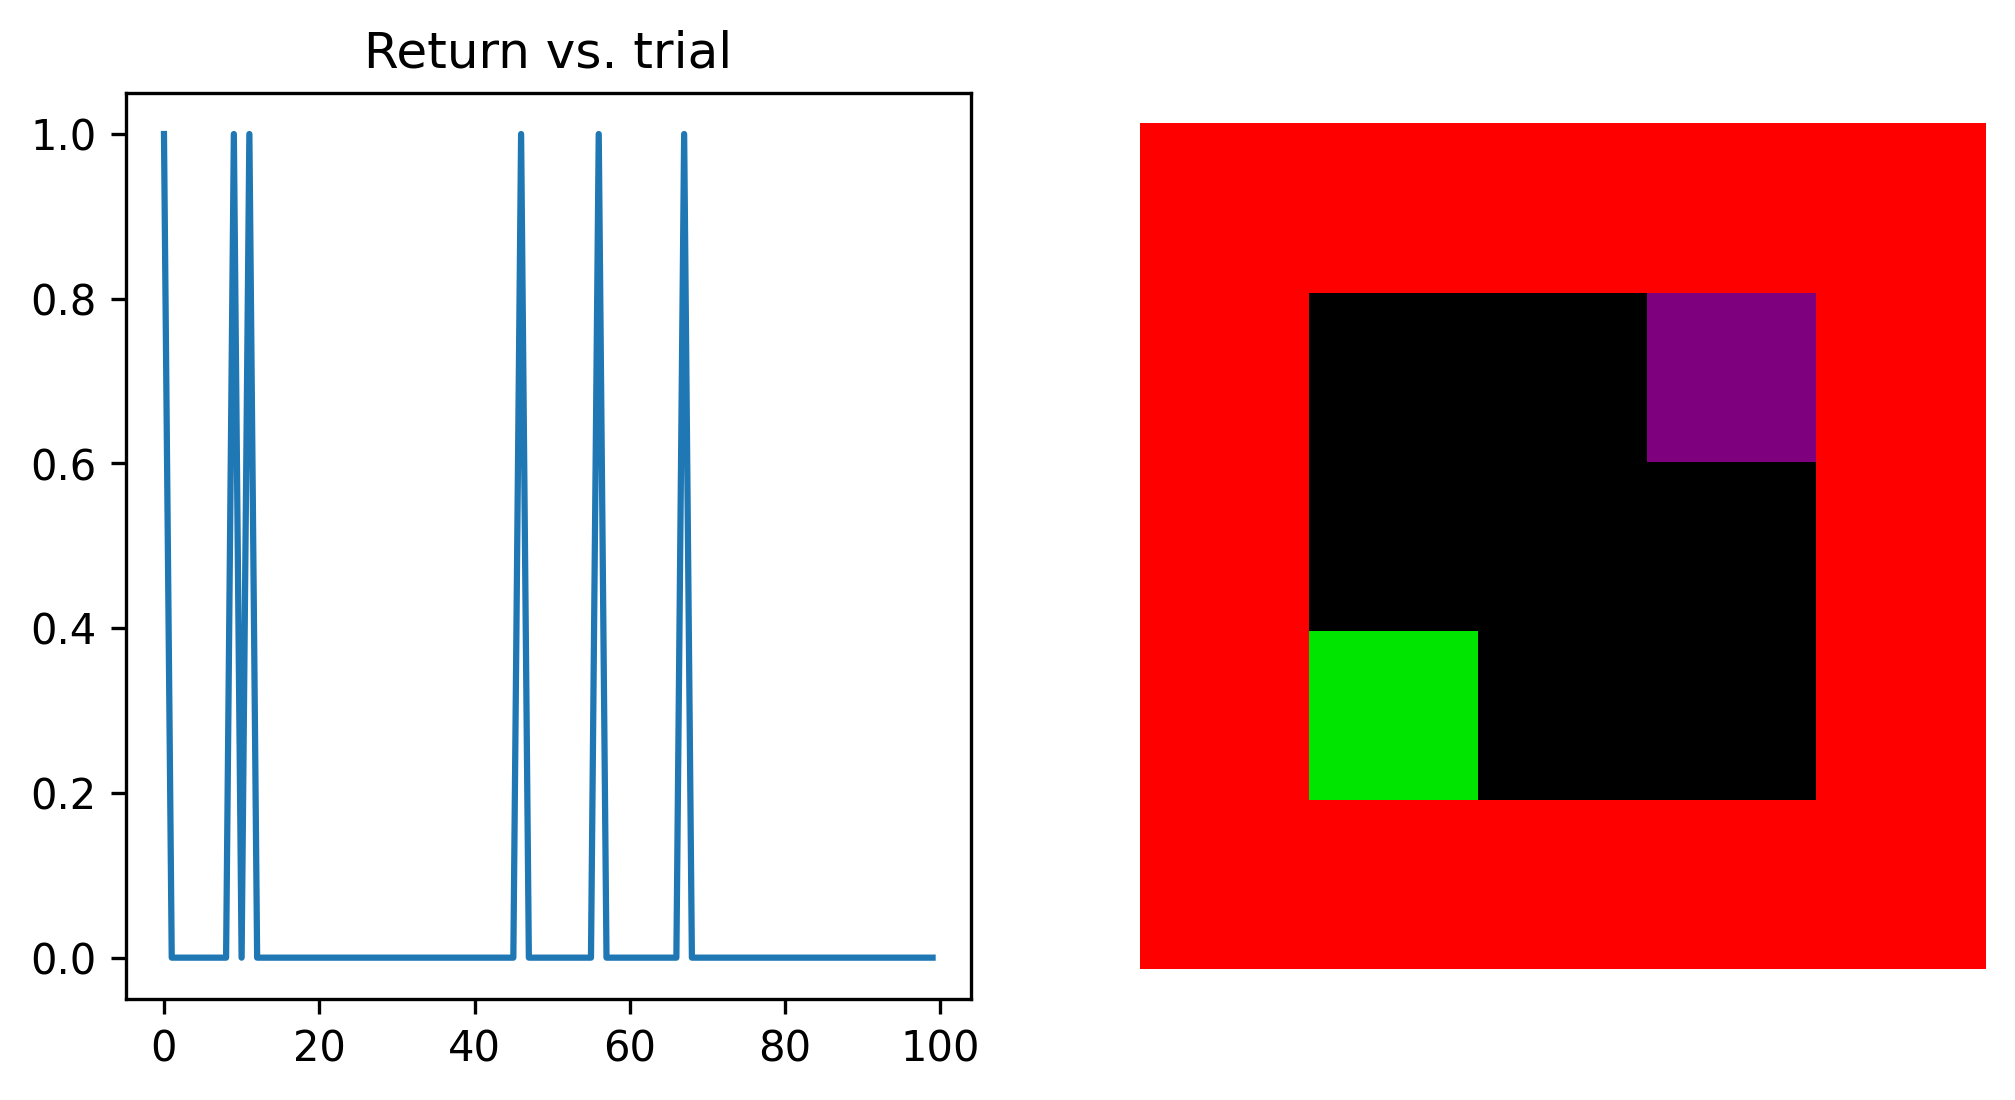

In [8]:
# NOW: the actual training loop

# the four directions of motion [delta_jx,delta_jy]:
directions=np.array([[0,1],[0,-1],[1,0],[-1,0]])

# steps inside one trajectory
nsteps=5

# total number of trials, i.e. trajectories
ntrials=100
skipsteps=5 # don't plot every trial

# storing all the state/action pairs of the current trajectory
states=np.zeros([nsteps,2], dtype='int')
actions=np.zeros(nsteps, dtype='int')

# storing all the returns, for all trials:
Returns=np.zeros(ntrials)

# store cost function for the training step (out of curiosity)
costs=np.zeros(ntrials)

# try many trajectories:
for trial in range(ntrials):

    # make a new maze (a new one in each trial!)
    world=np.array(empty_maze(width=M,height=M),dtype='int')
    # a map of rewards (the 'chests' are here!)
    reward=np.zeros([M,M])
    # random selection of reward sites (treasure chests)
    for n in range(num_chests): 
        jx_target,jy_target=np.random.randint(M,size=2)
        if world[jx_target,jy_target]==0: # empty, keep it!
            reward[jx_target,jy_target]+=1
    # set return to zero for this trajectory:
    R=0
    # initial position:
    jx,jy=1,1

    # prepare an input image for the network
    input_image=np.zeros([1,M,M,3]) # first index would be batchsize
    input_image[0,:,:,0]=world 
    # we can set this now, since it will not change during this trial

    # we need to store all the input images
    # for a whole trajectory, for convenience
    # so we can afterwards make the training step 
    # on this set of images as one batch!
    input_images=np.zeros([nsteps,M,M,3])
    
    # go through all time steps
    for t in range(nsteps):
        # Obtain the policy prediction given the current
        # situation:
        # the maze map is already stored
        # inside input_image[0,:,:,0]
        # but the treasure map and
        # the robot position need to be updated
        input_image[0,:,:,1]=reward # current treasure map!
        input_image[0,jx,jy,2]=1 # indicate position of robot!
        # now: evaluate policy network:
        policy_p=Policy.predict_on_batch(input_image)[0]
        
        # now policy_p is an array of 4 probabilities
        # [0] was needed to get rid of first index, which
        # would be the batchsize (but we have a batchsize of 1)
        
        # make a random step, according to the policy distribution
        p=np.random.uniform()
        cumulative_distribution=np.cumsum(policy_p)
        for pick in range(4):
            if p<cumulative_distribution[pick]:
                break

        # record the move
        states[t,0]=jx
        states[t,1]=jy
        actions[t]=pick
        input_images[t,:,:,:]=input_image[0,:,:,:] # store for later
        
        # now make the move
        jx_new,jy_new=np.array([jx,jy])+directions[pick]

        # really make it if there is no wall:
        if world[jx_new,jy_new]==0: # is empty, can move!
            input_image[0,jx,jy,2]=0 # delete robot position in map
            jx,jy=jx_new,jy_new
        # get a reward if on a treasure chest!
        r=reward[jx,jy]
        if r>0:
            reward[jx,jy]-=1 # delete treasure!
        R+=r
   
    # store the return
    Returns[trial]=R
    
    # use policy gradient update rule to adjust
    # probabilities!
    # make an array for the target policy distributions
    # for all time steps
    target_distributions=np.zeros([nsteps,4])
    for t in range(nsteps): # go through the trajectory again
        a=actions[t] # remember the action taken at step t
        target_distributions[t,a]=R # reinforce that action!
    costs[trial]=Policy.train_on_batch(input_images,target_distributions)
    
    # visualize!
    if trial%skipsteps==0 or trial==ntrials-1:
        # show what's happened in this trajectory
        clear_output(wait=True)
        fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8,4))
        ax[0].plot(Returns) # all the returns, in all trials
        ax[0].set_title("Return vs. trial")
        
        picture=np.zeros([M,M,3]) # last index: red/green/blue
        picture[:,:,0]=world # walls are red
        for j in range(nsteps): # highlight trajectory
            picture[states[j,0],states[j,1],1]=0.5*(1.0+(1.0*j)/nsteps)
        # put a bright pixel at the positions visited
        picture[:,:,2]+=0.5*reward # highlight the target sites!
        picture[:,:,0]+=0.5*reward

        # show picture (transpose is needed because
        # otherwise the first coordinate jx is plotted upwards,
        # not to the right)
        ax[1].imshow(np.transpose(picture,[1,0,2]),origin='lower')
        ax[1].axis('off')
        
        #ax[1,0].imshow(np.transpose(policy[:,:,0]),origin='lower')
        #ax[1,0].axis('off')
        #ax[1,0].set_title("prob(move up)")
        #ax[1,1].imshow(np.transpose(policy[:,:,2]),origin='lower')
        #ax[1,1].set_title("prob(move right)")
        #ax[1,1].axis('off')
        plt.show()

## The deep policy gradient algorithm: 'fast' version (trains in parallel on many mazes, which  accelerates the policy network evaluation, since this can be done on a whole batch of input images)


In [3]:
# an empty playground... (even that turns out to be difficult enough currently)
def empty_maze(width,height):
    mymaze=np.zeros([width,height],dtype='int')
    mymaze[:,0]=1
    mymaze[:,-1]=1
    mymaze[0,:]=1
    mymaze[-1,:]=1
    return(mymaze)

In [4]:
def run_one_trial(Policy,M,nsteps,input_image,input_images,reward,jx,jy,
                  actions,position,world,allsamples,batchsize,
                  directions,
                 delete_treasure=True):
    """
    Run one trial starting at position jx,jy, storing returns in R, storing
    actions and position, using input_image and world.
    This will return R,input_images.
    """    
    # set return to zero for this trajectory:
    R=np.zeros([batchsize])
    
    # go through all time steps
    for t in range(nsteps):
        # Obtain the policy prediction given the current
        # situation:
        # the maze map is already stored
        # inside input_image[0,:,:,0]
        # but the treasure map and
        # the robot position need to be updated
        input_image[:,:,:,1]=reward # current treasure map!
        input_image[allsamples,jx,jy,2]=1 
        # last line indicates position of robot(s)! (for whole batch)
        # note: this uses advanced numpy indexing, so we use
        # three equal-length integer arrays a,b,c to do the
        # equivalent of
        #  for k in range(n):
        #      input_image[a[k],b[k],c[k],2]=1
        #
        # now: evaluate policy network on the whole batch:
        # this is where we gain efficiency!
        policy_p=Policy.predict_on_batch(input_image)
        
        #print(policy_p)
        if np.any(policy_p>1.001):
            print("Oops, policy out of range:",policy_p)
        
        # now policy_p is an array of [batchsize,4] probabilities
        
        # make a random step, according to the policy distribution
        p=np.random.uniform(size=batchsize)
        cumulative_distribution=np.cumsum(policy_p,axis=1) # note axis argument
        pick=np.argmax(cumulative_distribution>p[:,None],axis=1) 
        # will give the index of the first entry that exceeds p, which is
        # exactly what we need (pick will still be a 1D array of 'batchsize' length)

        # record the move
        #print(pick[0],jx[0],jy[0])
        actions[:,t]=pick
        position[:,t,0]=jx
        position[:,t,1]=jy
        input_images[:,t,:,:,:]=np.copy(input_image) # store for later
        
        # now make the move
        jx_new,jy_new=jx+directions[pick][:,0],jy+directions[pick][:,1]
            
        # really make it if there is no wall:
        # again, we do this for all samples in parallel,
        # thanks to advanced numpy array indexing
        can_move=np.array(world[allsamples,jx_new,jy_new]==0,dtype='int') # 1 if can move
        input_image[allsamples,jx,jy,2]-=can_move # delete old position only if we can move
        jx,jy=jx*(1-can_move)+jx_new*can_move,jy*(1-can_move)+jy_new*can_move
        
        #print("-->",jx[0],jy[0])
        
        # get a reward if on a treasure chest!
        r=reward[allsamples,jx,jy] # will be array of batchsize length
        if delete_treasure:
            reward[allsamples,jx,jy]-=1*(r>0) # delete treasure!
        R+=r
        
    return(R)


In [5]:
def prepare_batch(batchsize,world,M,num_chests,jx,jy,full_maze=False):
    """
    prepare one batch, return:
        reward,input_image
    Arrays world and jx,jy need already to exist, but will
    be filled with values.
    """
    # a map of rewards (the 'chests' are here!)
    reward=np.zeros([batchsize,M,M],dtype='float')

    for sample in range(batchsize):
        # make a new maze (a new one in each trial!)
        if full_maze:
            world[sample,:,:]=np.array(maze(width=M,height=M),dtype='int')            
        else:
            world[sample,:,:]=np.array(empty_maze(width=M,height=M),dtype='int')
        # random selection of reward sites (treasure chests)
        for n in range(num_chests): 
            while True:
                jx_target,jy_target=np.random.randint(low=2,high=M-2,size=2)  # avoid close to boundary!
                if world[sample,jx_target,jy_target]==0: # empty, keep it!
                    reward[sample,jx_target,jy_target]+=1
                    break
                    
    # pick random initial position:
    for sample in range(batchsize):
        while True:
            jx_try,jy_try=np.random.randint(low=2,high=M-2,size=2) # avoid close to boundary!
            if world[sample,jx_try,jy_try]==0:
                jx[sample],jy[sample]=jx_try,jy_try
                break
            
    # prepare an input image for the network
    input_image=np.zeros([batchsize,M,M,3],dtype='float')
    input_image[:,:,:,0]=world 
    # we can set this now, since it will not change during this trial

    return(reward,input_image)


In [9]:
def try_pos(x,y,Policy,M,world,reward):
    try_image=np.zeros([1,M,M,3])
    try_image[0,x,y,2]=1.0
    try_image[0,:,:,0]=world[0,:,:]
    try_image[0,:,:,1]=reward[0,:,:]
    
    return( Policy.predict_on_batch(try_image)[0]  )

def plot_try_pos(M,num_actions,Policy,world,reward,
                 directions,ax=None,target=None):
    
    P=np.zeros([M,M,num_actions])
    for x in range(M):
        for y in range(M):
            P[x,y,:]=try_pos(x,y,Policy,M,world,reward)
    
    if ax is None:
        fig,ax=plt.subplots(ncols=num_actions,nrows=1)
        ax_was_none=True
    else:
        ax_was_none=False
        
    for n in range(num_actions):
        ax[n].imshow(np.transpose(P[:,:,n]+world[0,:,:]),origin='lower',vmin=0.0,vmax=1.0)
        ax[n].axis('off')
        ax[n].set_title(str(directions[n]))
        if target is not None:
            ax[n].scatter([target[0]],[target[1]],c="orange")
    
    if np.any(np.abs(np.sum(P,axis=2)-1.0)>0.01):
        print("WARNING: Probabilities do not sum up to 1!", np.sum(P,axis=1))
    if ax_was_none:
        plt.show()

In [10]:
def run_RL(M=7,eta=0.0001,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=50,test_batchsize=5,
          nsteps=15,ntrials=1000,skipsteps=20,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=False,choose_random_positions_for_single_maze=False,
          place_chest=None,kernel_size=5,num_channels=5,
          full_maze=False):
    """
    Run the full policy gradient RL algorithm, for a number of trials.
    """
    global orig_test_reward,orig_test_world
    
    # first define the policy neural network
    Policy=Sequential()
    Policy.add(Conv2D(num_channels,kernel_size=kernel_size,input_shape=(M,M,3),
                    activation="elu",padding="same"))
    Policy.add(Conv2D(num_channels,kernel_size=kernel_size,
                    activation="elu",padding="same"))
    Policy.add(Conv2D(num_channels,kernel_size=kernel_size,
                    activation="elu",padding="same"))
    Policy.add(Conv2D(num_channels,kernel_size=kernel_size,
                    activation="elu",padding="same"))
    Policy.add(Flatten())
    Policy.add(Dense(num_actions,activation="softmax"))
    # the output layer with the probabilities

    # we have to use categorical cross entropy for the
    # policy gradient update rule!
    # also, we should not use adam (which tries to be adaptive),
    # but just plain old simple stochastic gradient descent,
    # if we want the policy gradient update to be correctly
    # implemented!
    if try_adam:
        Policy.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(learning_rate=eta))
    else:
        Policy.compile(loss='categorical_crossentropy',
                       optimizer=optimizers.SGD(learning_rate=eta,clipnorm=1.0))

    # NOW: the setup

    # the four directions of motion [delta_jx,delta_jy]:
    directions=np.array([[1,0],[0,-1],[0,1],[-1,0],[0,0]])

    # storing all the actions of the current trajectory
    actions=np.zeros([batchsize,nsteps], dtype='int')
    position=np.zeros([batchsize,nsteps,2], dtype='int')

    # same for test batch (which is smaller):
    test_actions=np.zeros([test_batchsize,nsteps], dtype='int')
    test_position=np.zeros([test_batchsize,nsteps,2], dtype='int')

    # we need to store all the input images
    # for a whole trajectory, for convenience
    # so we can afterwards make the training step 
    # on this set of images as one batch!
    input_images=np.zeros([batchsize,nsteps,M,M,3],dtype='float')
    test_input_images=np.zeros([test_batchsize,nsteps,M,M,3],dtype='float')

    # the current position, for all samples of the batch in parallel:
    jx,jy=np.zeros([batchsize],dtype='int'),np.zeros([batchsize],dtype='int')
    test_jx,test_jy=np.zeros([test_batchsize],dtype='int'),np.zeros([test_batchsize],dtype='int')

    # storing all the returns, for all trials:
    Returns=np.zeros([batchsize,ntrials])

    # the maze maps, for all samples in parallel:
    world=np.zeros([batchsize,M,M],dtype='int')
    test_world=np.zeros([test_batchsize,M,M],dtype='int')

    # store cost function for the training step (out of curiosity)
    costs=np.zeros(ntrials)

    # useful for some advanced array indexing:
    allsamples=np.arange(0,batchsize)
    test_allsamples=np.arange(0,test_batchsize)

    # generate test mazes on which the strategy will be
    # repeatedly illustrated:
    test_reward,test_input_image=prepare_batch(batchsize=test_batchsize,
                                    world=test_world,M=M,
                                    num_chests=num_chests,jx=test_jx,jy=test_jy,
                                              full_maze=full_maze)

    orig_test_reward=np.copy(test_reward)
    orig_test_world=np.copy(test_world)
    
    # special case: a single maze (not a fresh maze for every sample)
    if single_maze:
        if place_chest is not None:
            test_reward[0,:,:]=0
            test_reward[0,place_chest[0],place_chest[1]]=1.0
        
        for n in range(1,test_batchsize):
            test_reward[n,:,:]=test_reward[0,:,:]
            test_input_image[n,:,:,:]=test_input_image[0,:,:,:]
            test_world[n,:,:]=test_world[0,:,:]
        reward,input_image=prepare_batch(batchsize=batchsize,
                                        world=world,M=M,num_chests=num_chests,jx=jx,jy=jy,
                                              full_maze=full_maze)
        for n in range(batchsize):
            reward[n,:,:]=test_reward[0,:,:]
            input_image[n,:,:,:]=test_input_image[0,:,:,:]
            world[n,:,:]=test_world[0,:,:]
    w=np.where(test_reward[0,:,:]>0.5)
    chest_x=w[0][0] # position of treasure chest
    chest_y=w[1][0]

    costs=np.zeros(ntrials)

    # try many trajectories:
    for trial in range(ntrials):
        # prepare the mazes of the batch (and starting positions, and treasure distribution):
        if not single_maze: # generate a fresh maze for every sample in the batch
            reward,input_image=prepare_batch(batchsize=batchsize,
                                        world=world,M=M,num_chests=num_chests,jx=jx,jy=jy,
                                              full_maze=full_maze)
        else: # keep the one single maze
            for sample in range(batchsize):
                jx[sample],jy[sample]=1,1
                input_image[sample,:,:,2]=0
                input_image[sample,jx[sample],jy[sample],2]=1
       # the following good for starting from random positions, but the same maze
                if choose_random_positions_for_single_maze:
                    while True:
                        jx_try,jy_try=np.random.randint(M,size=2)
                        jx_try,jy_try=np.random.randint(M,size=2)
                        if world[sample,jx_try,jy_try]==0:
                            jx[sample],jy[sample]=jx_try,jy_try
                            input_image[sample,:,:,2]=0
                            input_image[sample,jx[sample],jy[sample],2]=1 # place robot
                            break        

        # run a single full trial
        # as usual, all arrays are passed by reference and will be filled
        # with new values in this routine
        R=run_one_trial(Policy,M,nsteps,input_image=input_image,
                 input_images=input_images,
                 reward=reward, jx=jx, jy=jy,
                 actions=actions,position=position,world=world,
                allsamples=allsamples,batchsize=batchsize,
                        directions=directions,
                delete_treasure=delete_treasure)

        # store the return
        Returns[:,trial]=R

    #    w=np.argmax(R)
    #     for t in range(nsteps):
    #         print(position[w,t,0],position[w,t,1],end=" | ")
    #     print("R = ",R[w])

        # use policy gradient update rule to adjust
        # probabilities!
        # first: make an array for the target policy distributions
        # for all time steps (those that contain 'R' in the slot
        # of the action that was actually taken!)
        target_distributions=np.zeros([batchsize,nsteps,num_actions])
        for t in range(nsteps): # go through the trajectory again
            a=actions[:,t] # remember the action taken at step t
            target_distributions[allsamples,t,a]=R # reinforce that action!
        costs[trial]=Policy.train_on_batch(np.reshape(input_images,[batchsize*nsteps,M,M,3]),
                                           np.reshape(target_distributions,[batchsize*nsteps,num_actions]))
        # we needed the reshape to make sure the input is still
        # of shape [total_batchsize,M,M,3]
        # ...only now total_batchsize is larger!
        # this will run through the update algorithm a larger number
        # of samples in parallel, which again is very efficient!

        # visualize!
        if do_visualize and trial%skipsteps==0 or trial==ntrials-1:
            if do_show_test_batch:
                current_test_reward=np.copy(test_reward) # avoid changes in the test_reward!
                R_test=run_one_trial(Policy,M,nsteps,input_image=test_input_image,
                     input_images=test_input_images,
                     reward=current_test_reward, jx=test_jx, jy=test_jy,
                     actions=test_actions,position=test_position,
                    world=test_world,allsamples=test_allsamples,
                    batchsize=test_batchsize,directions=directions,
                    delete_treasure=delete_treasure)

            clear_output(wait=True)
            fig=plt.figure(constrained_layout=True,
                           figsize=(num_actions,3))
            gs=fig.add_gridspec(ncols=num_actions,nrows=3)
            returns_plot=fig.add_subplot(gs[0:2,:])

            # show all the returns so far (averaged over the batch for each trial)
            returns_plot.plot(np.average(Returns,axis=0)) 
            # all the returns, in all trials (averaged over batch!)
            returns_plot.set_title("Return vs trial ("+str(batchsize)+" trajs/trial)")

            if do_show_test_batch:
                n_test_plots=test_batchsize
            else:
                n_test_plots=num_actions

            test_plot=[]
            for n in range(n_test_plots):
                test_plot.append(fig.add_subplot(gs[2,n]))

            if not do_show_test_batch:
                plot_try_pos(M,num_actions,Policy,orig_test_world,orig_test_reward,
                             directions,ax=test_plot,target=[chest_x,chest_y])
            else:
                # show what's happened in this test trial
                for n in range(test_batchsize):
                    # draw the trajectory of current batch sample 0!
                    picture=np.zeros([M,M,3]) # last index: red/green/blue
                    picture[:,:,0]=test_world[n,:,:] # walls are red
                    for j in range(nsteps): # highlight trajectory
                        picture[test_position[n,j,0],test_position[n,j,1],1]=0.5*(1.0+(1.0*j)/nsteps)
                    # put a bright pixel at the positions visited
                    # highlight the target sites!
                    picture[:,:,2]+=1*(test_reward[n,:,:]>0)

                    # show picture (transpose is needed because
                    # otherwise the first coordinate jx is plotted upwards,
                    # not to the right)
                    test_plot[n].imshow(np.transpose(picture,[1,0,2]),origin='lower')
                    test_plot[n].axis('off')
            plt.show()
 

## Tests (in an empty maze: just trying to find the right path from a fixed starting point to a fixed treasure chest...)

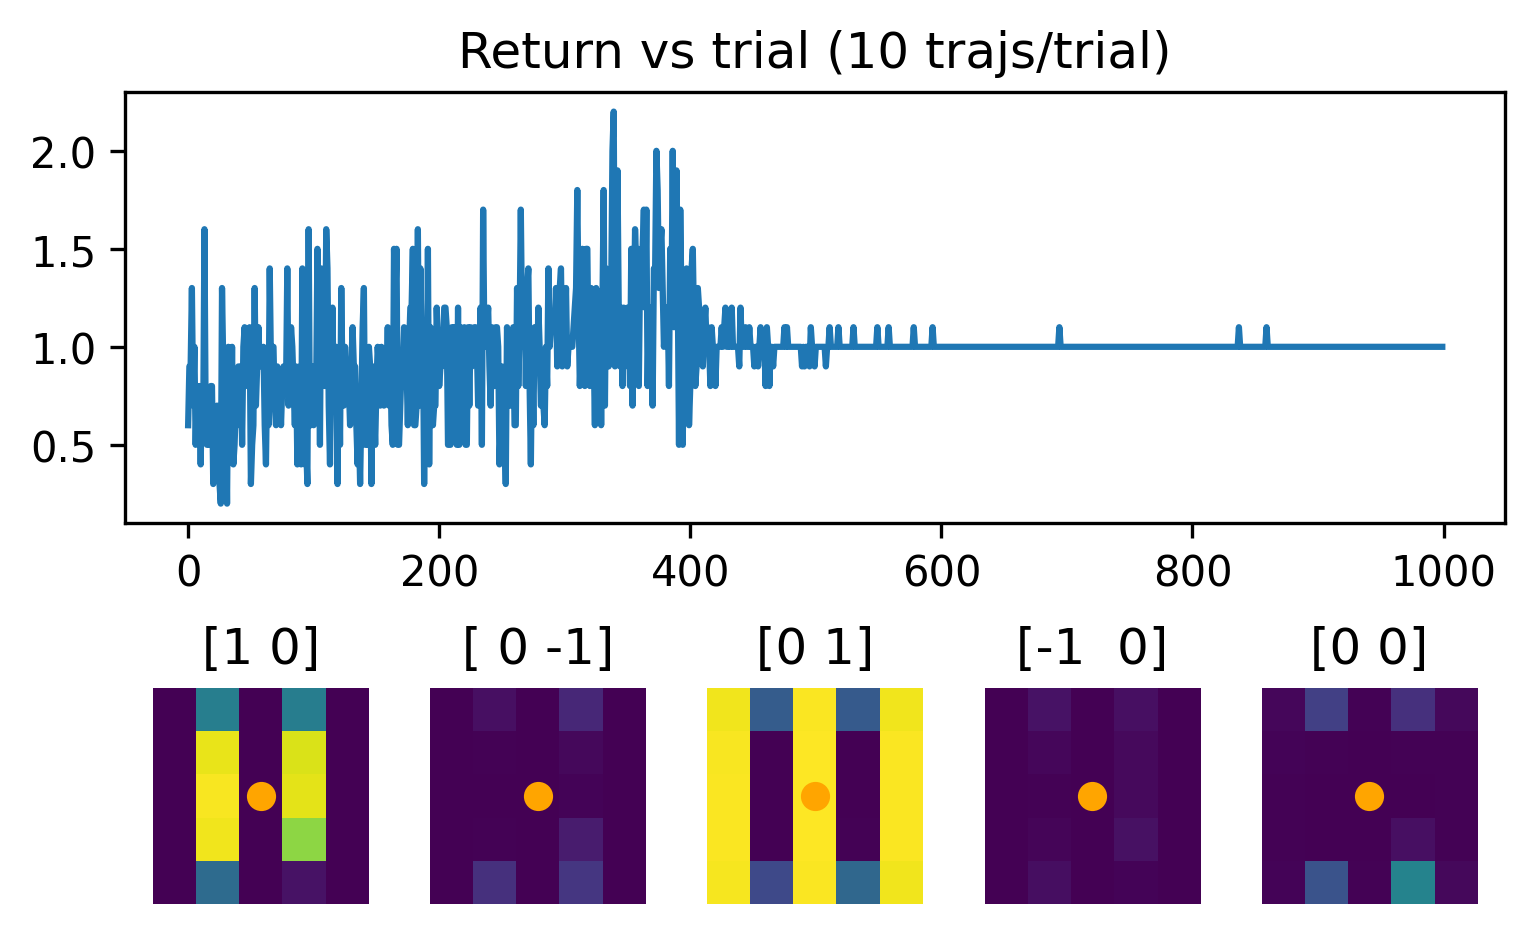

In [381]:
run_RL(M=5,eta=0.01,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=1000,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=False,choose_random_positions_for_single_maze=False)


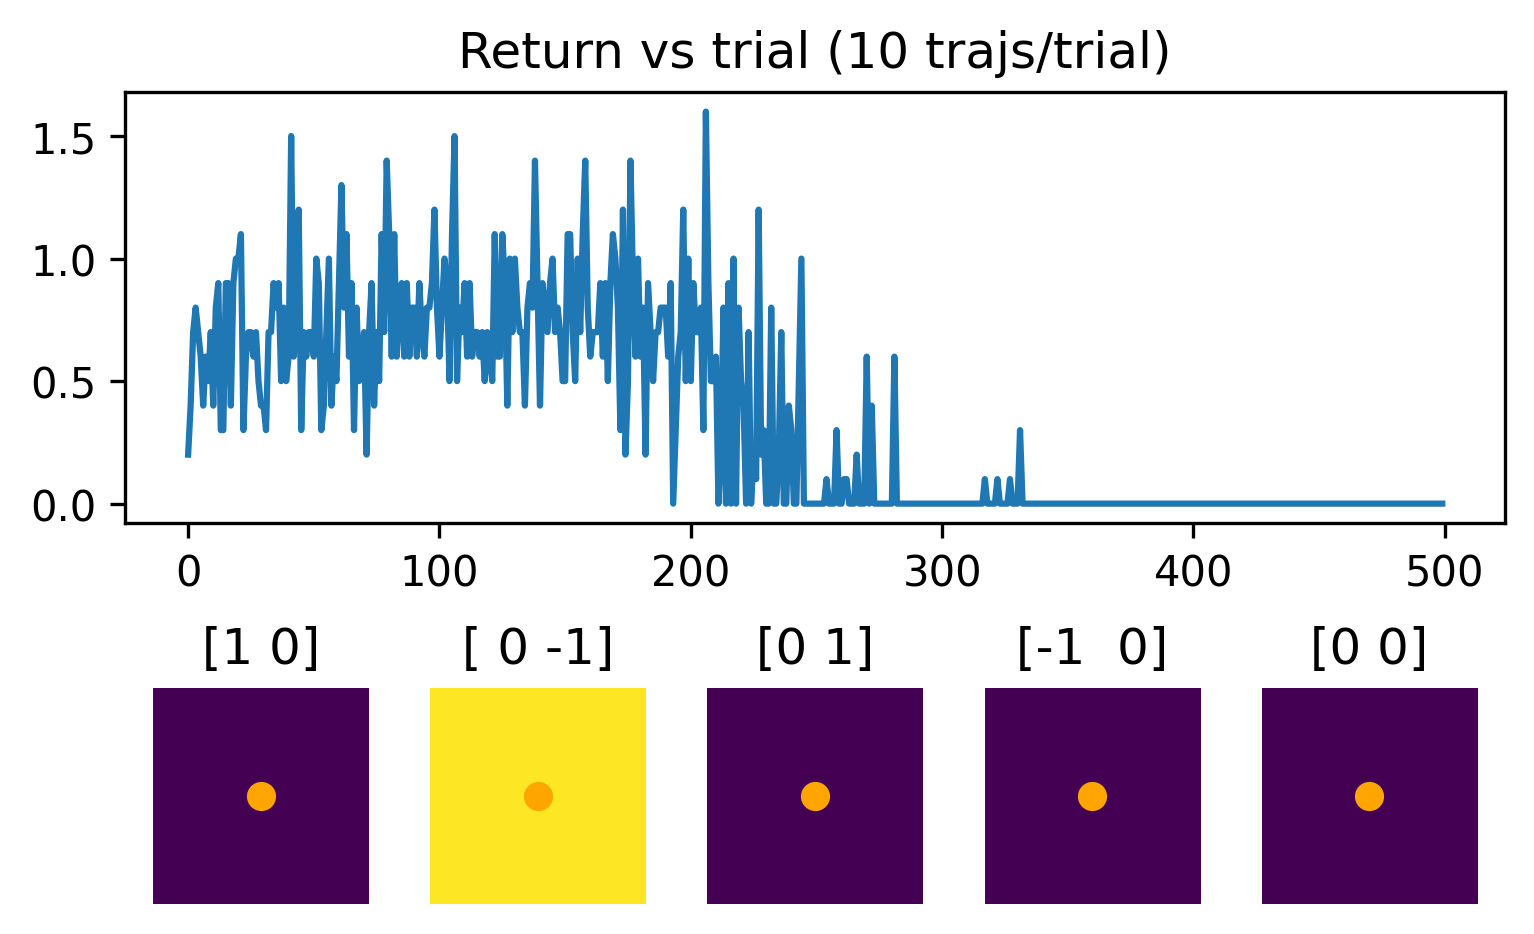

In [383]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.01,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=False,choose_random_positions_for_single_maze=False,
      place_chest=[2,2])


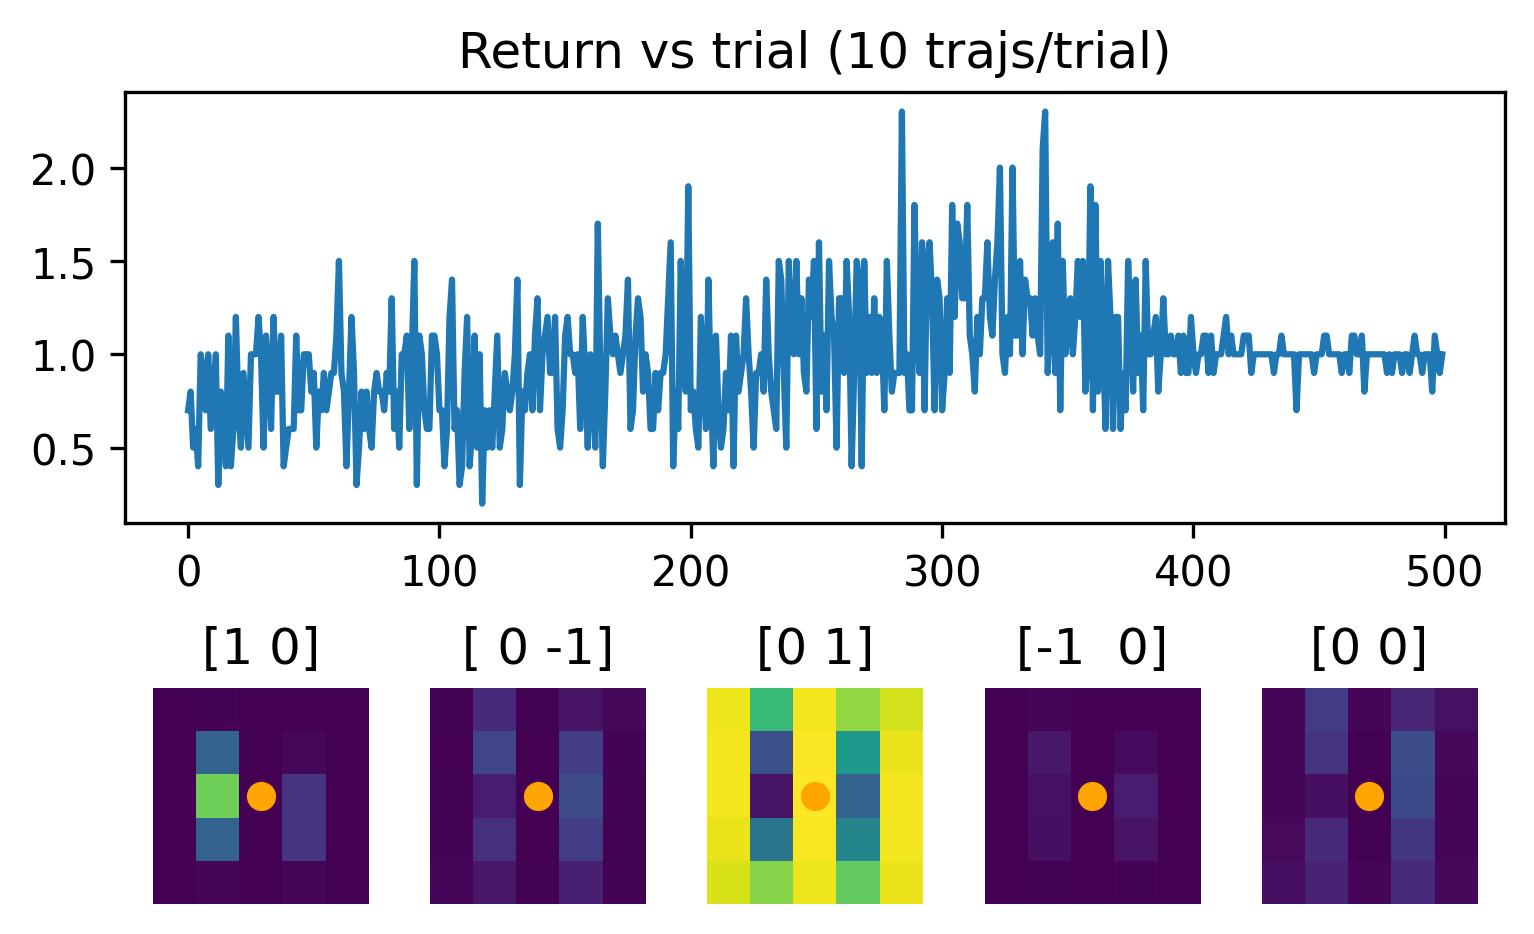

In [384]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.01,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=False,choose_random_positions_for_single_maze=False,
      place_chest=[2,2])



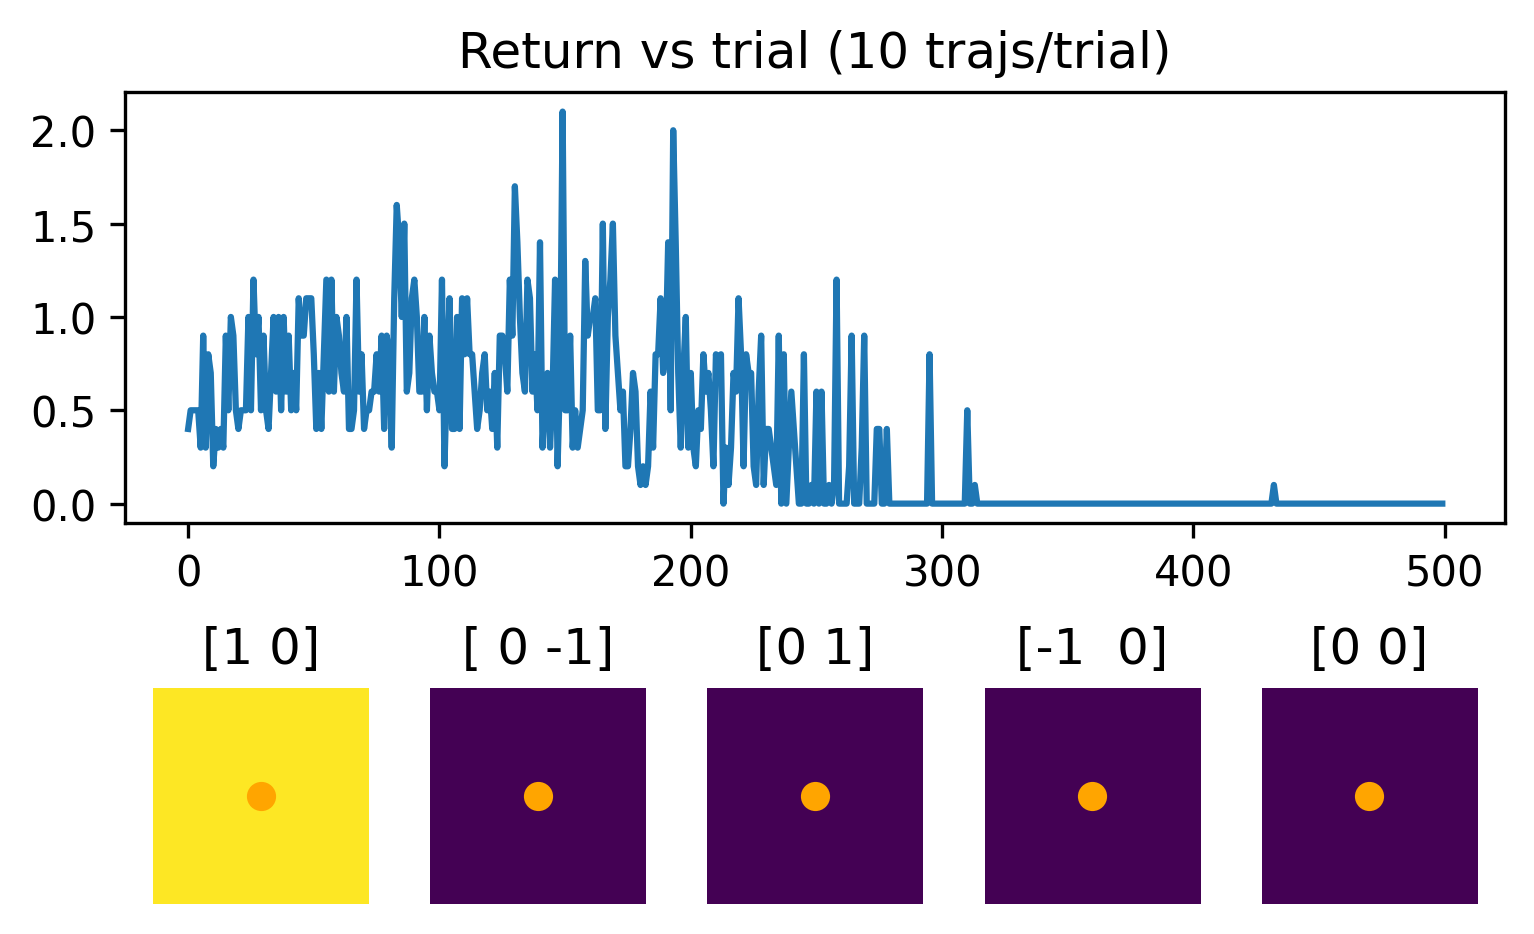

In [385]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.01,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=False,choose_random_positions_for_single_maze=False,
      place_chest=[2,2])



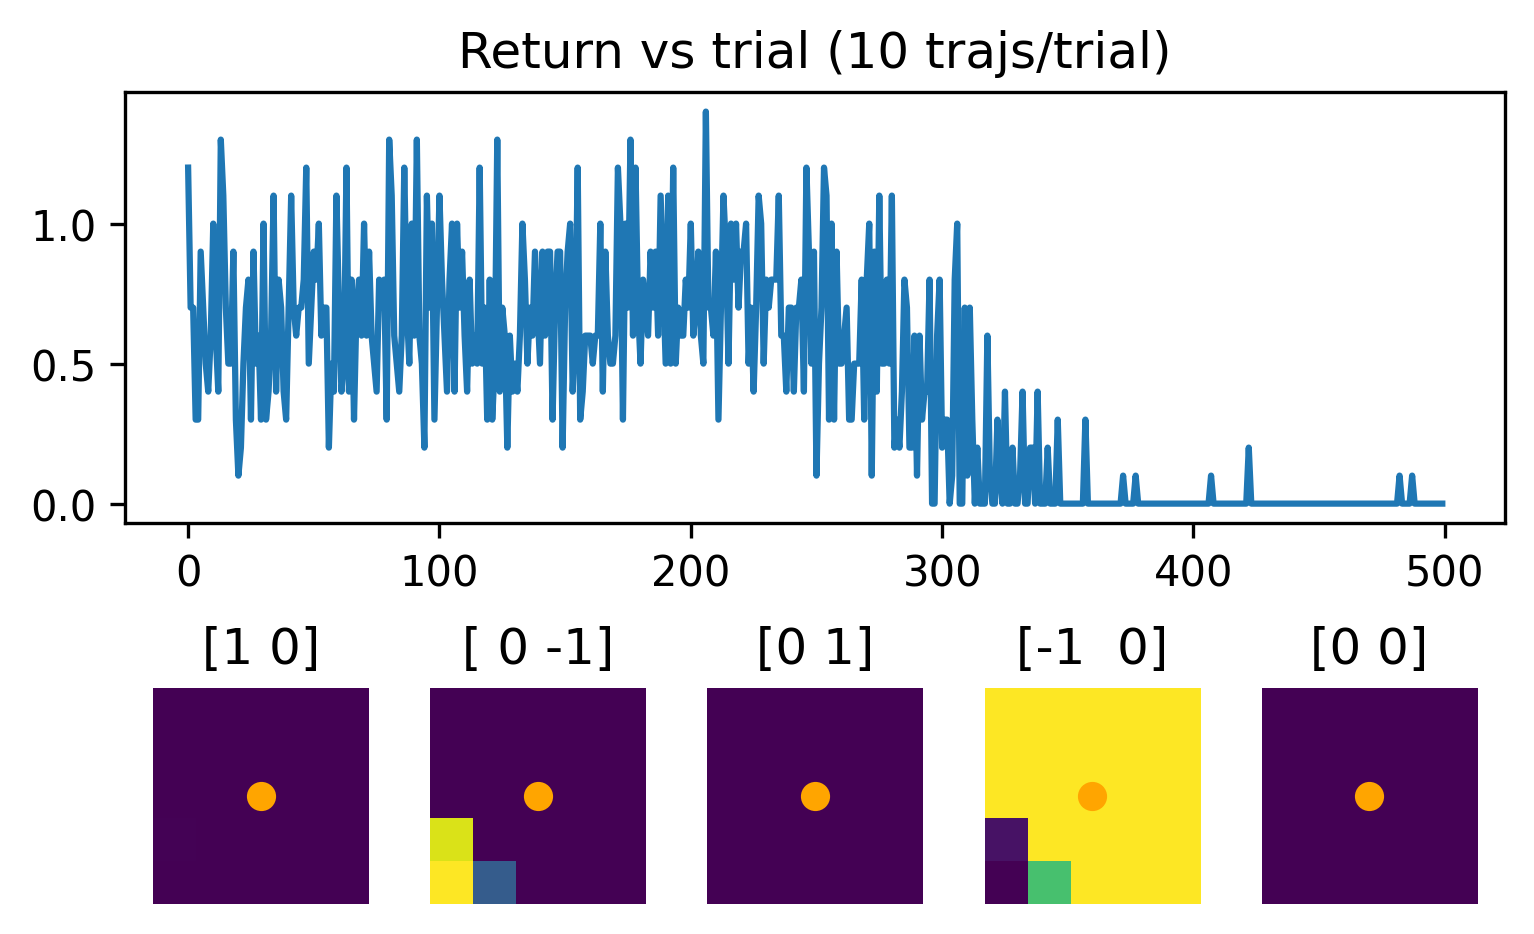

In [387]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.01,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=False,choose_random_positions_for_single_maze=False,
      place_chest=[2,2], kernel_size=3)


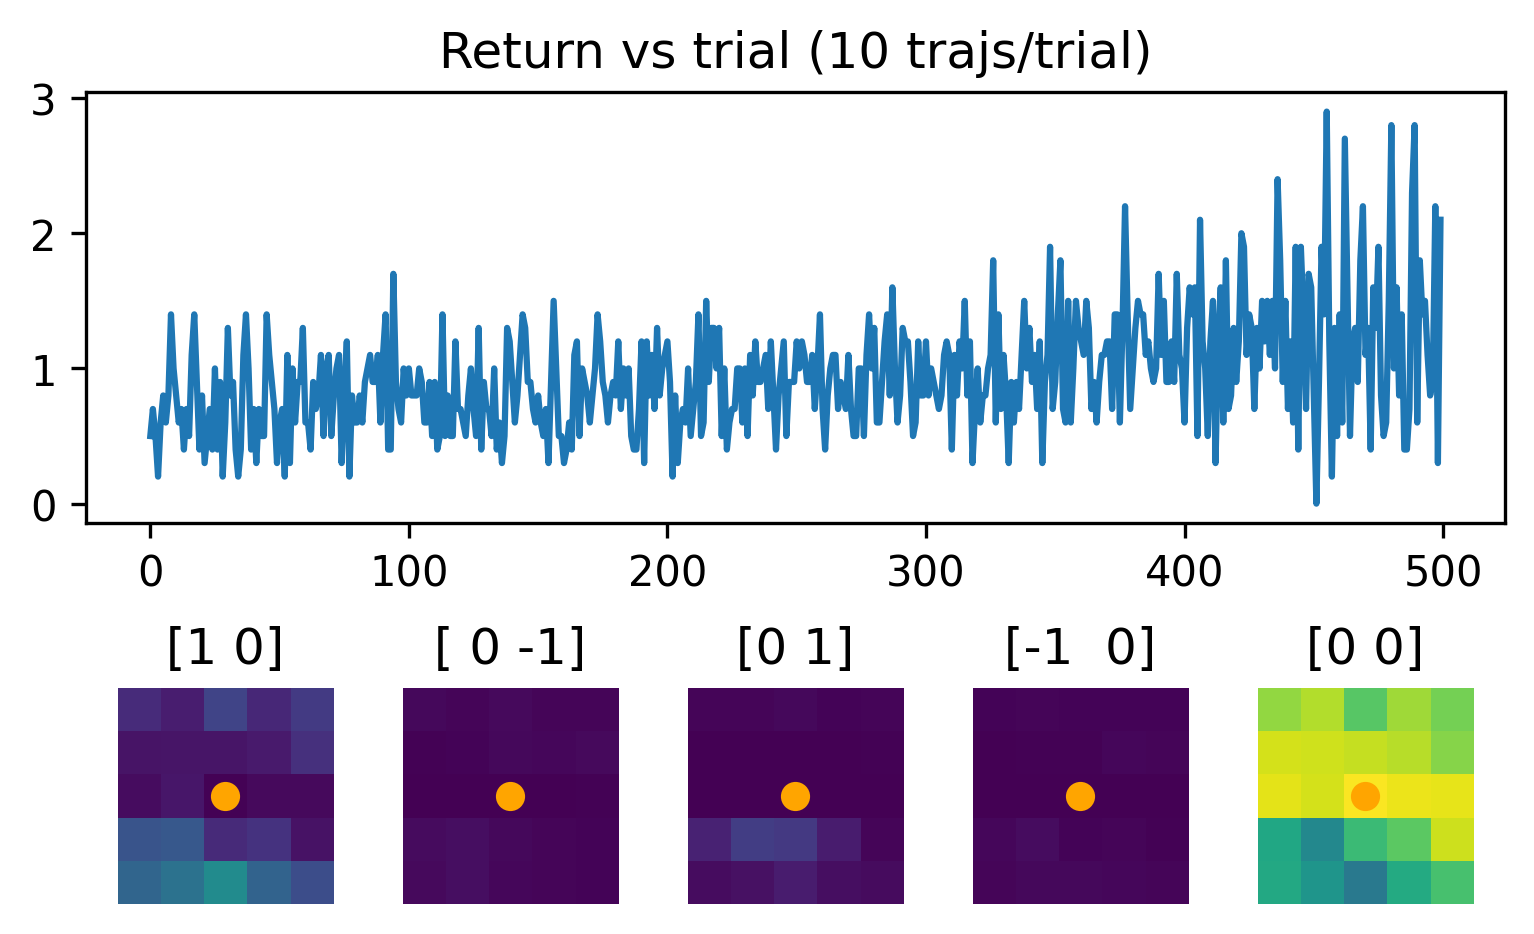

In [389]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.01,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=False,choose_random_positions_for_single_maze=False,
      place_chest=[2,2], kernel_size=3)

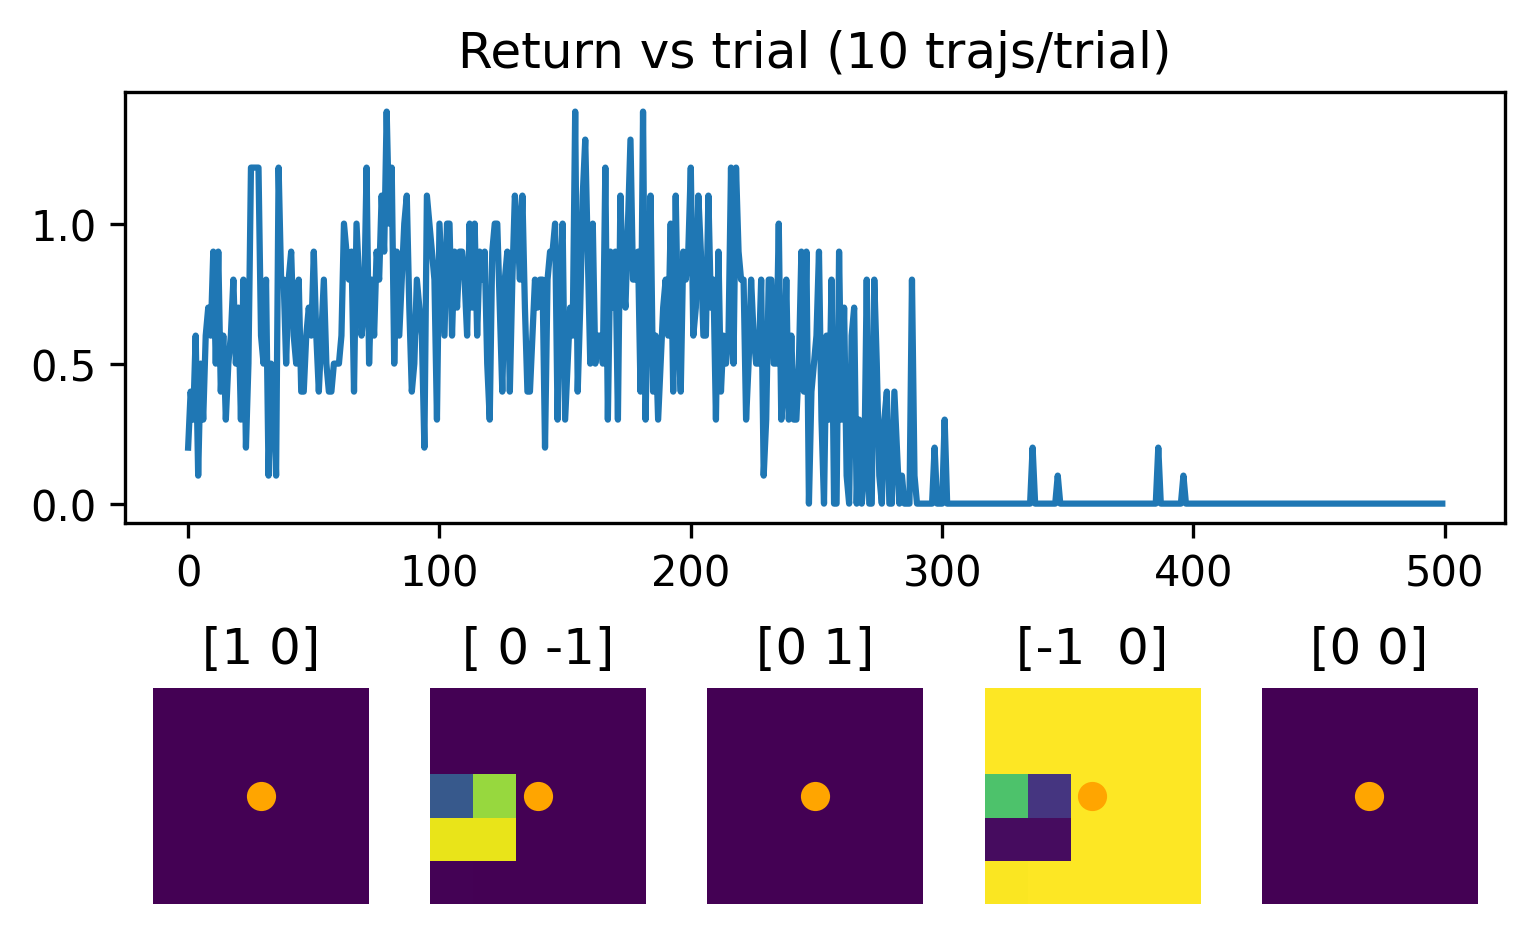

In [390]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.01,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=False,choose_random_positions_for_single_maze=False,
      place_chest=[2,2], kernel_size=3)

## Now: using adam

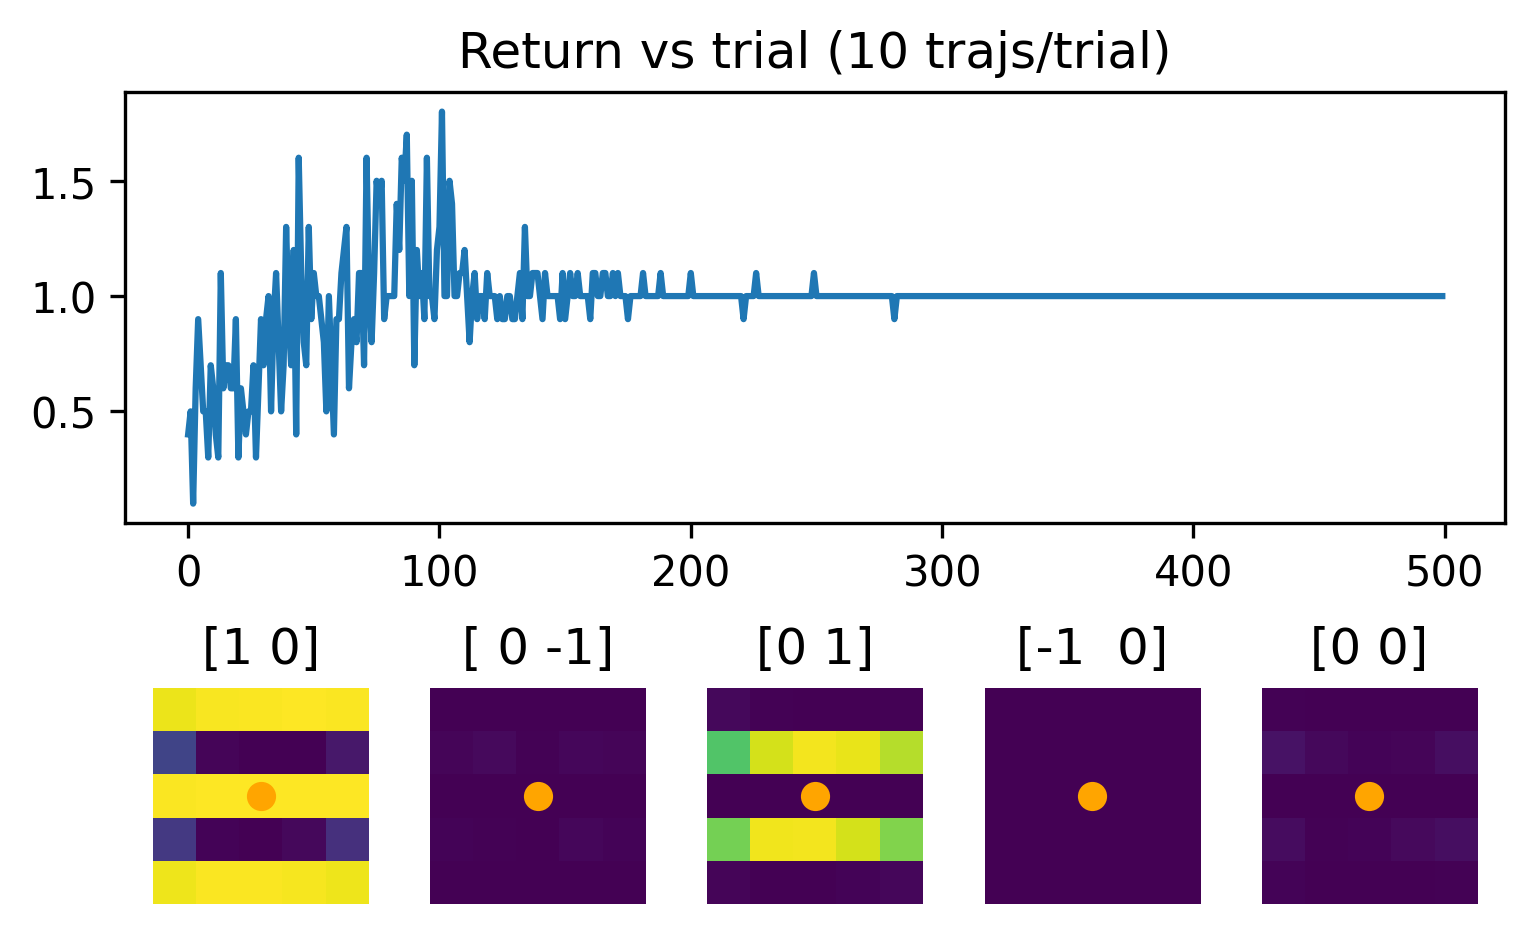

In [392]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.001,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=True,choose_random_positions_for_single_maze=False,
      place_chest=[2,2], kernel_size=3)

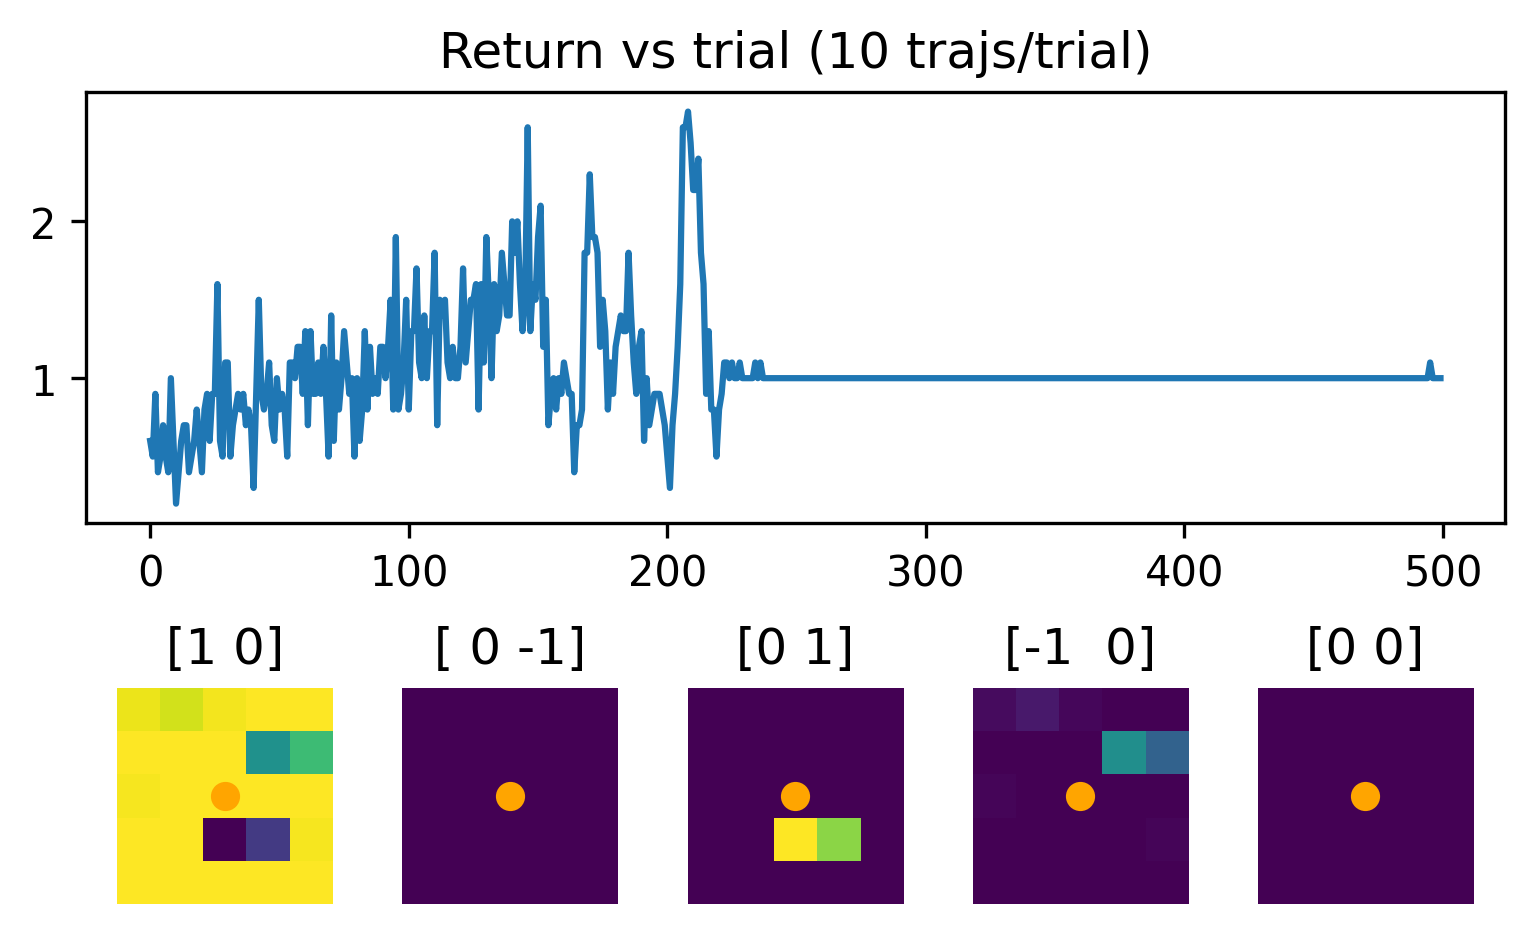

In [393]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.001,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=True,choose_random_positions_for_single_maze=False,
      place_chest=[2,2], kernel_size=3)

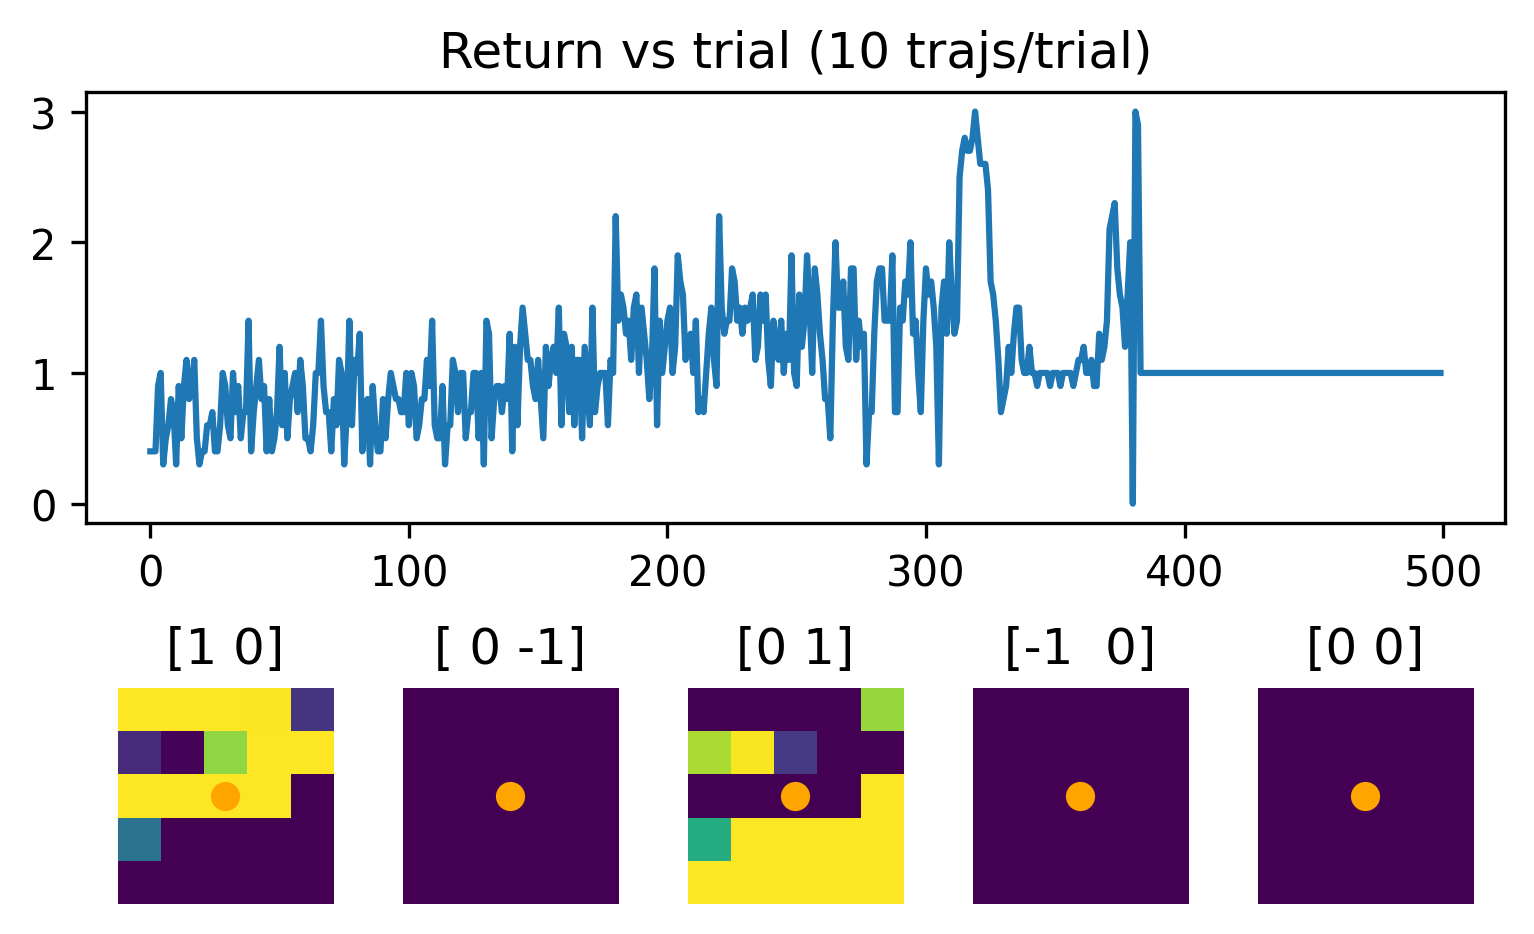

In [394]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.0005,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=True,choose_random_positions_for_single_maze=False,
      place_chest=[2,2], kernel_size=3)

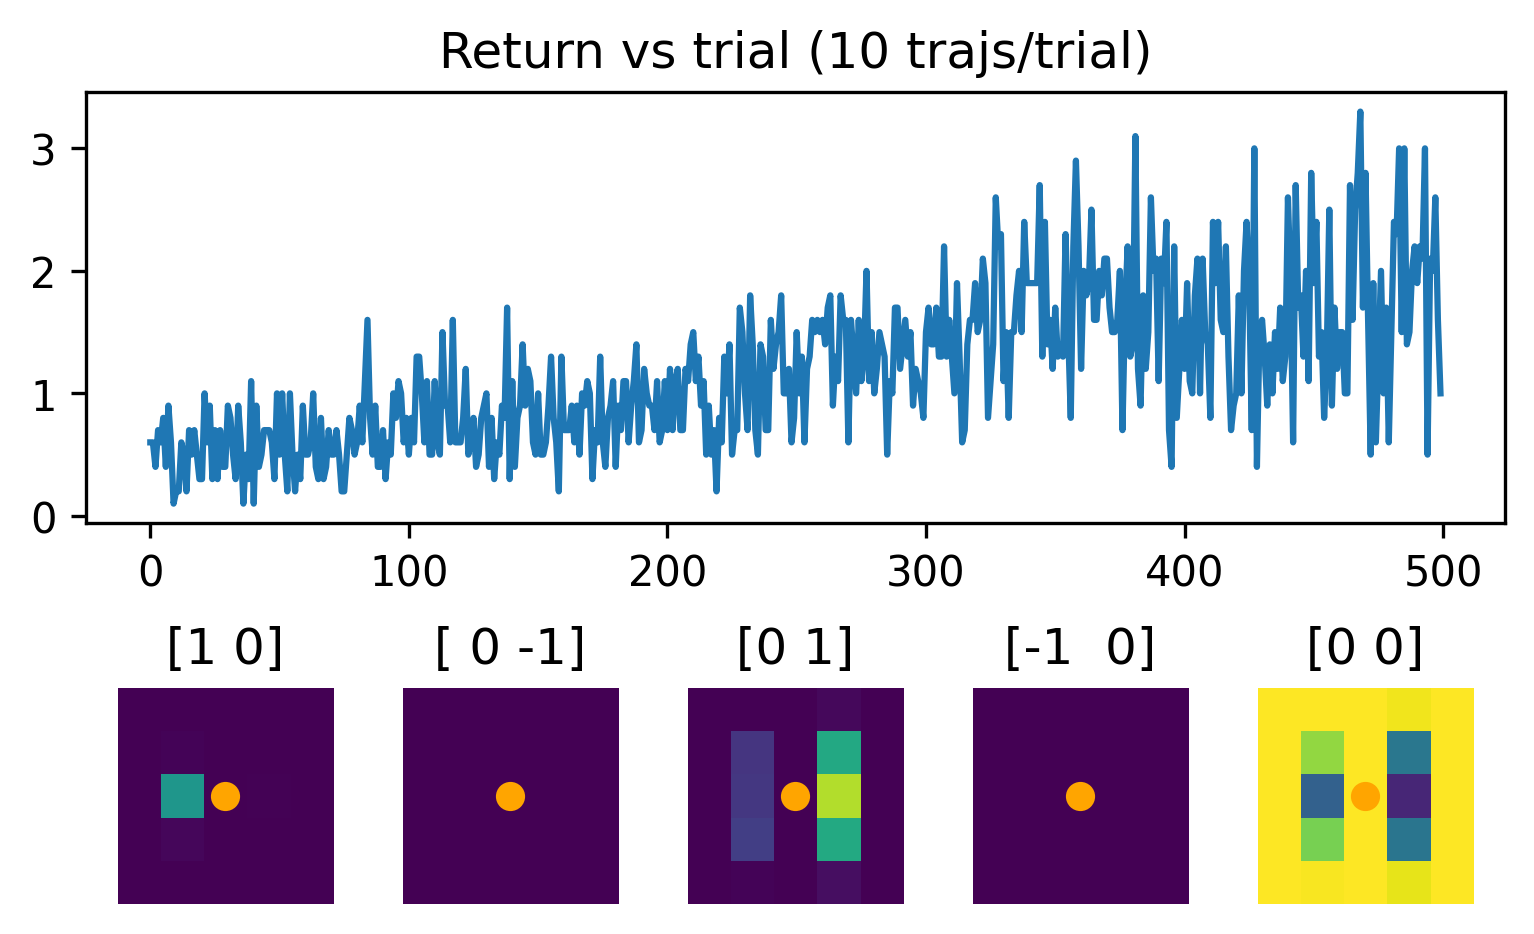

In [395]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.0002,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=True,choose_random_positions_for_single_maze=False,
      place_chest=[2,2], kernel_size=3)

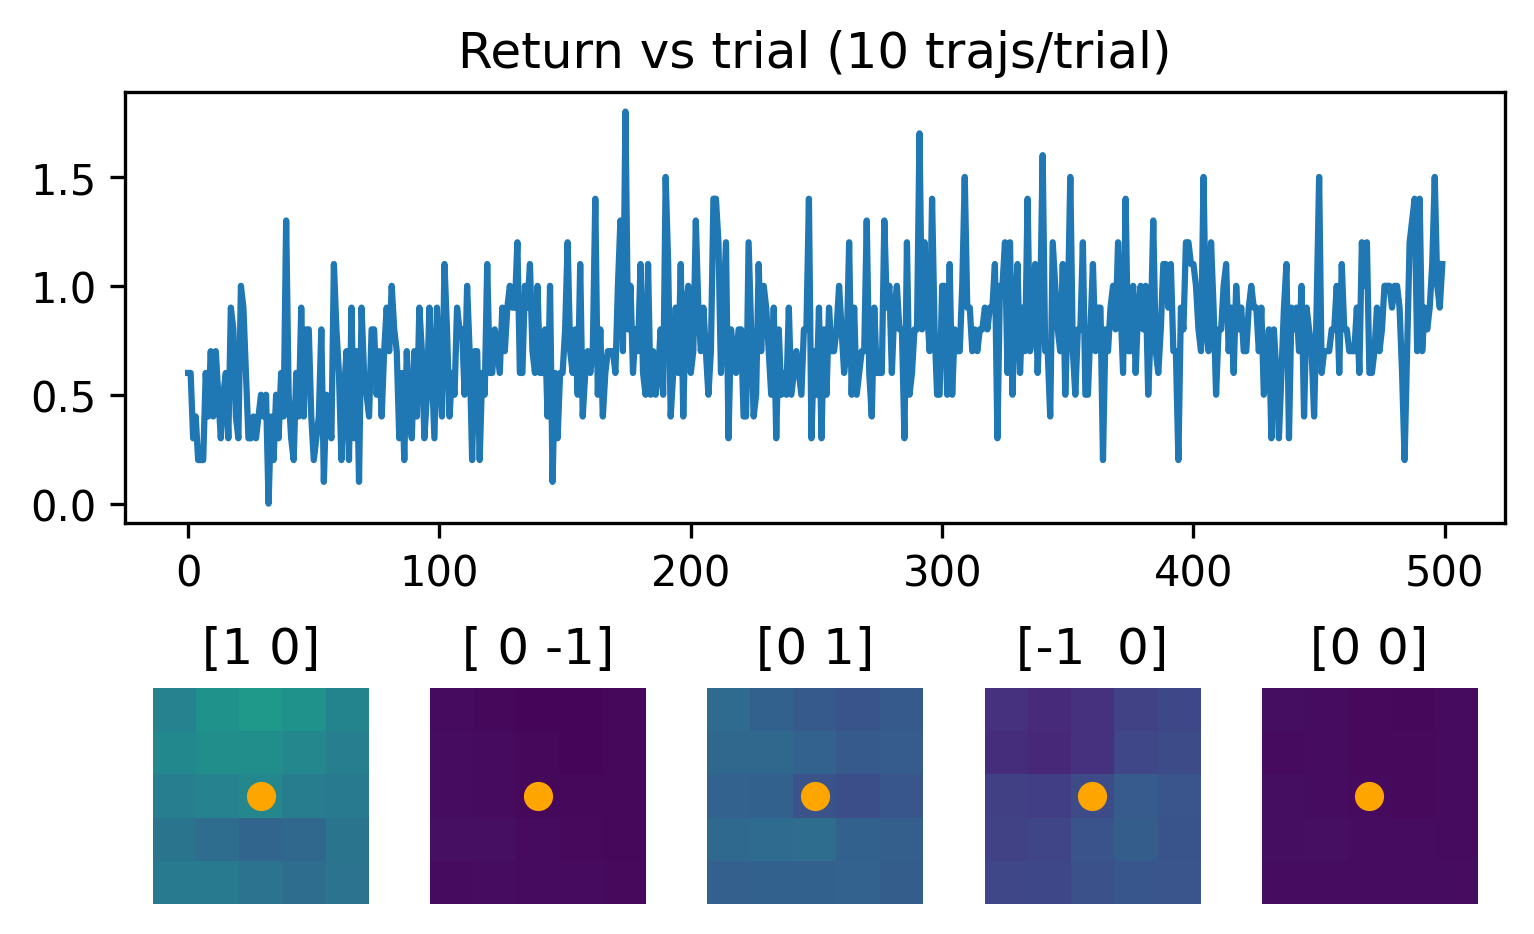

In [396]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.0002,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=True,choose_random_positions_for_single_maze=False,
      place_chest=[2,2], kernel_size=3)

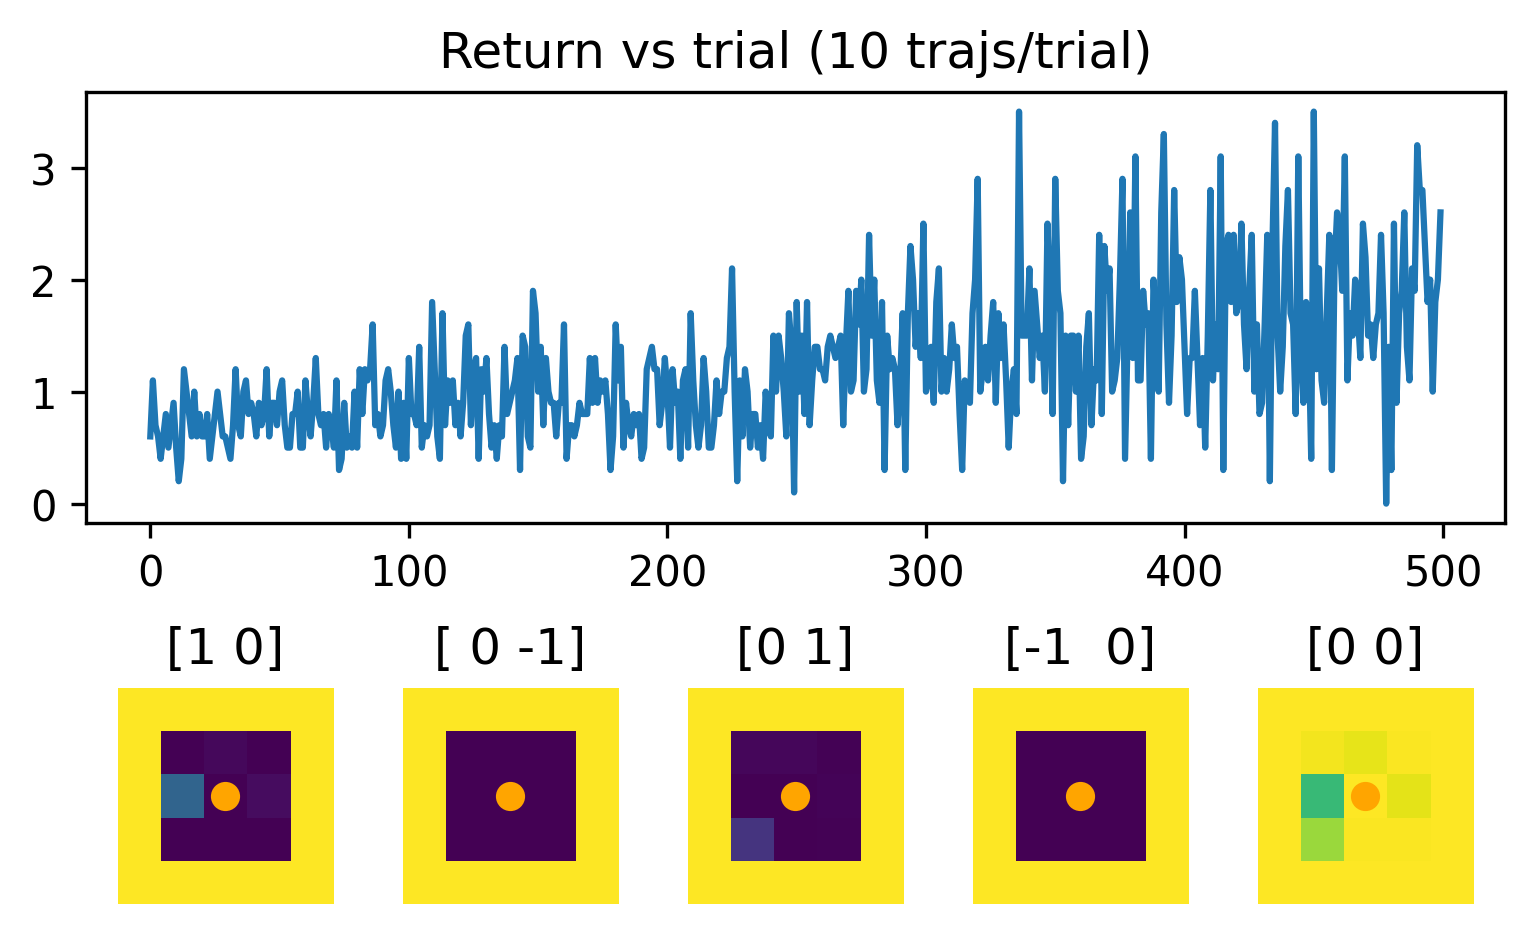

In [425]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.0002,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=True,choose_random_positions_for_single_maze=False,
      place_chest=[2,2], kernel_size=3)

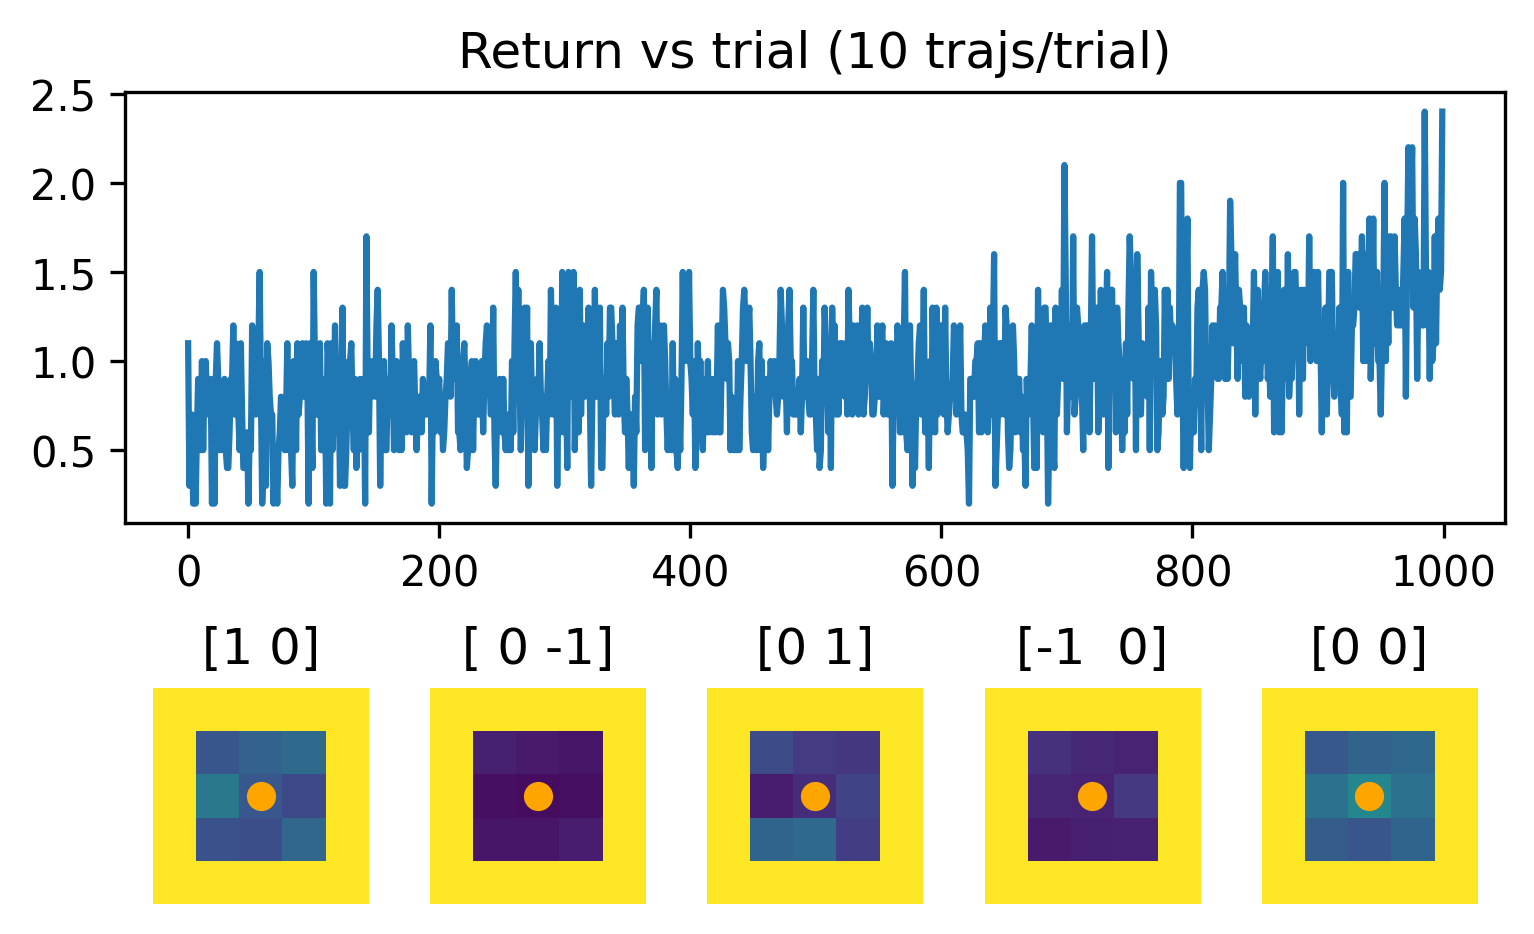

In [426]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.0001,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=1000,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=True,choose_random_positions_for_single_maze=False,
      place_chest=[2,2], kernel_size=3)

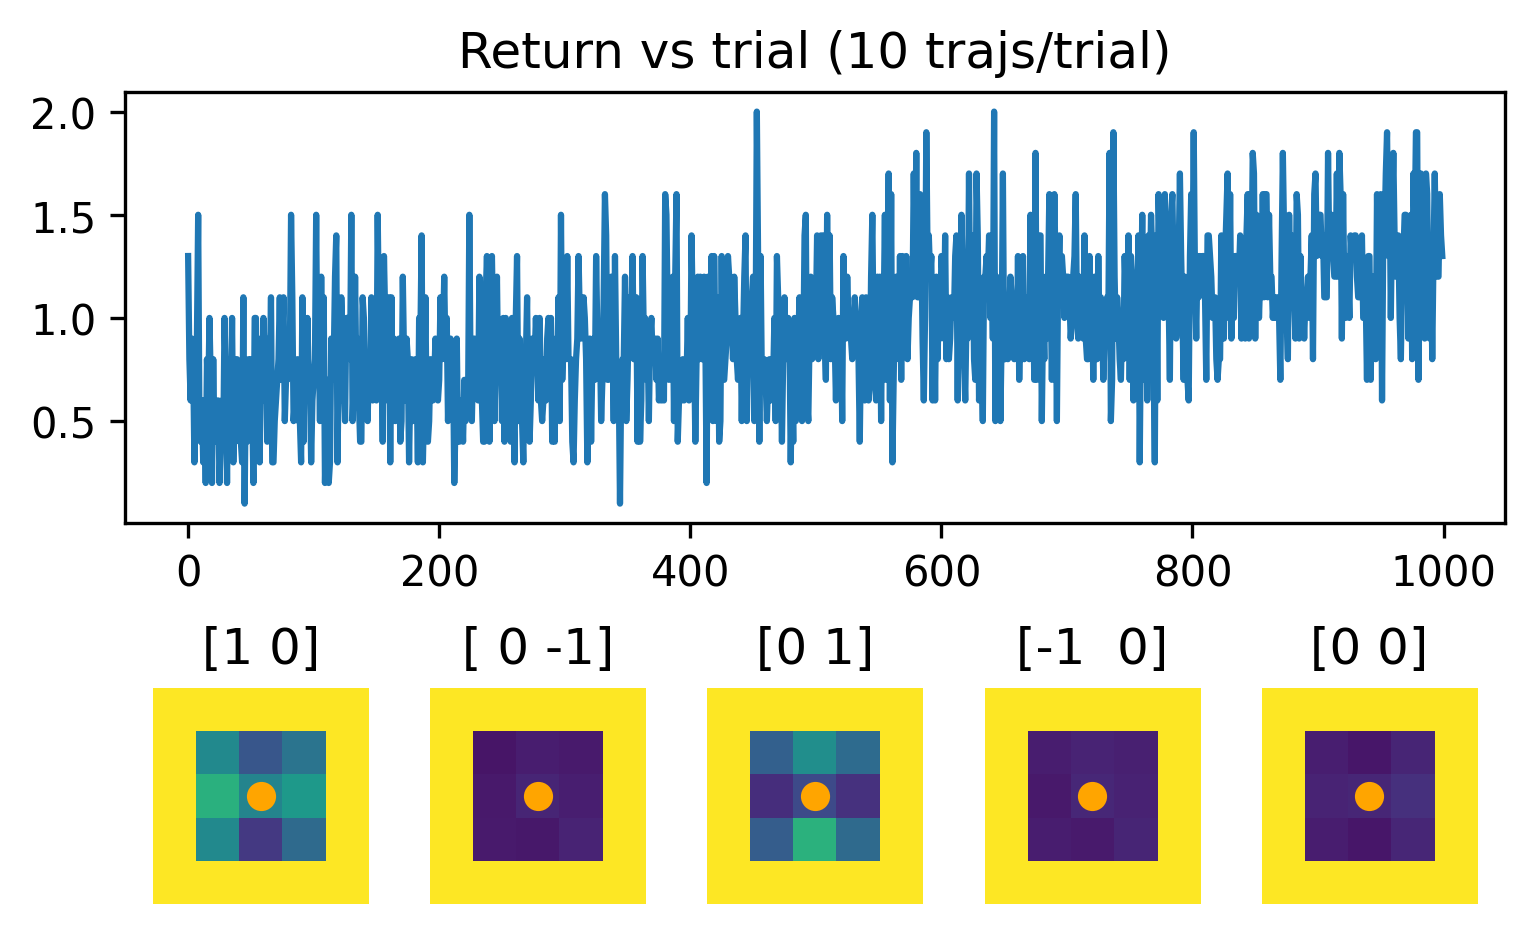

In [427]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.0001,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=1000,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=True,choose_random_positions_for_single_maze=False,
      place_chest=[2,2], kernel_size=3)

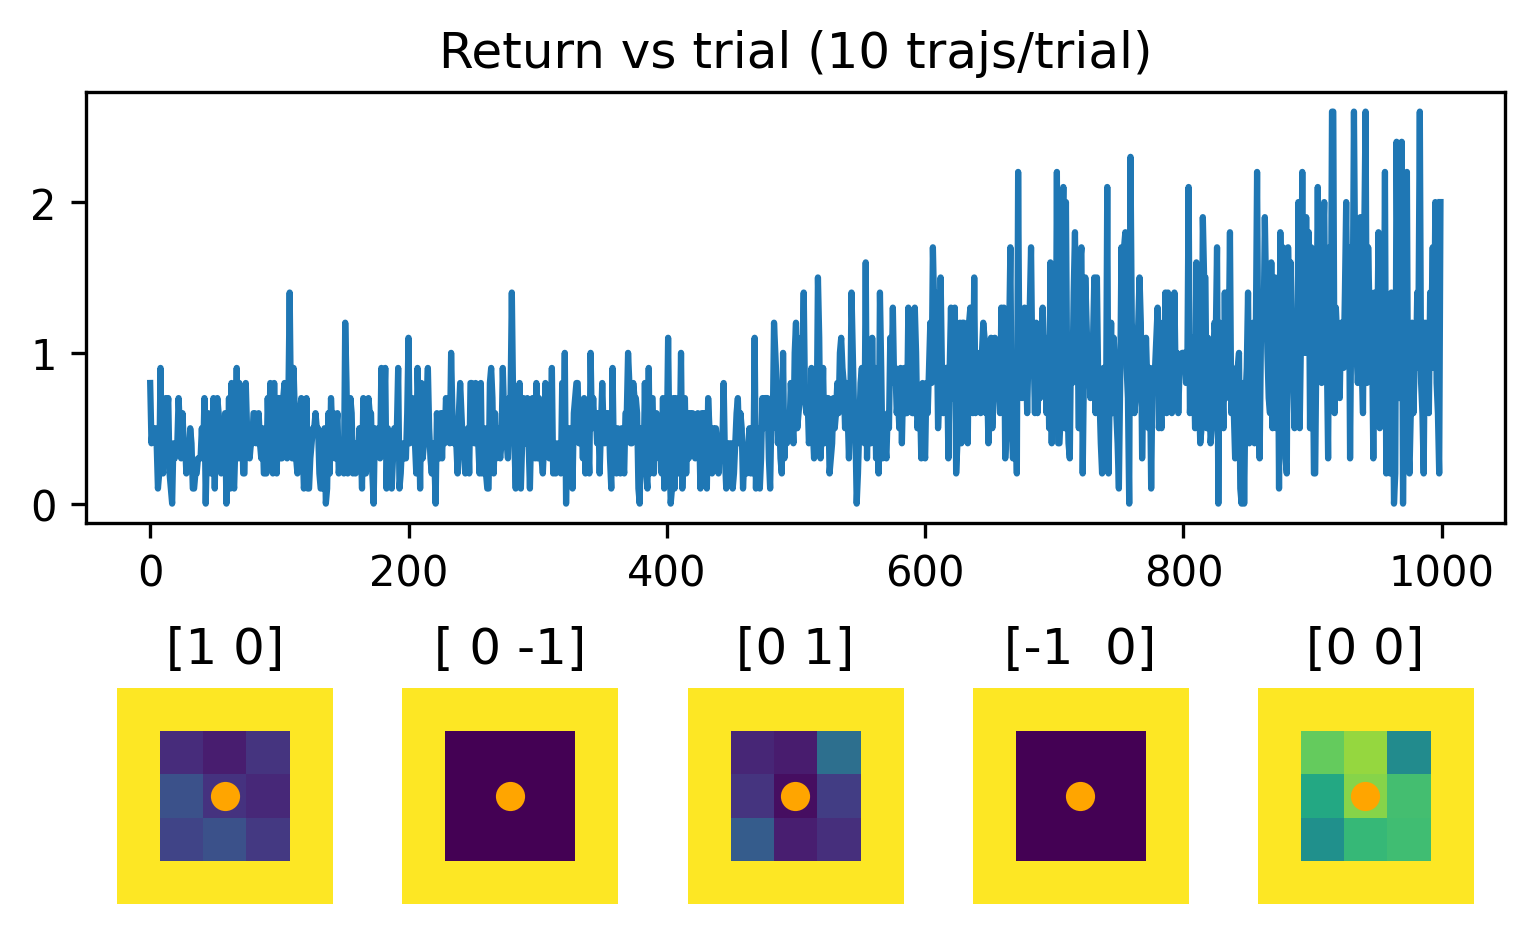

In [11]:
# the same again, with the same position of the chest:
run_RL(M=5,eta=0.0001,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=1000,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=True,choose_random_positions_for_single_maze=False,
      place_chest=[2,2], kernel_size=3)

# Tutorial: Explore parameters to get better performance!

These would include:
- the learning rate eta
- the batchsize
- whether to choose adam or stochastic gradient descent
- the size M of the maze and the number of time steps (nsteps) in a trajectory
- the layout of the neural network: kernel_size, num_channels, or possibly more changes in the network structure itself (inside run_RL)

## Train on arbitrary mazes (does not yet work)

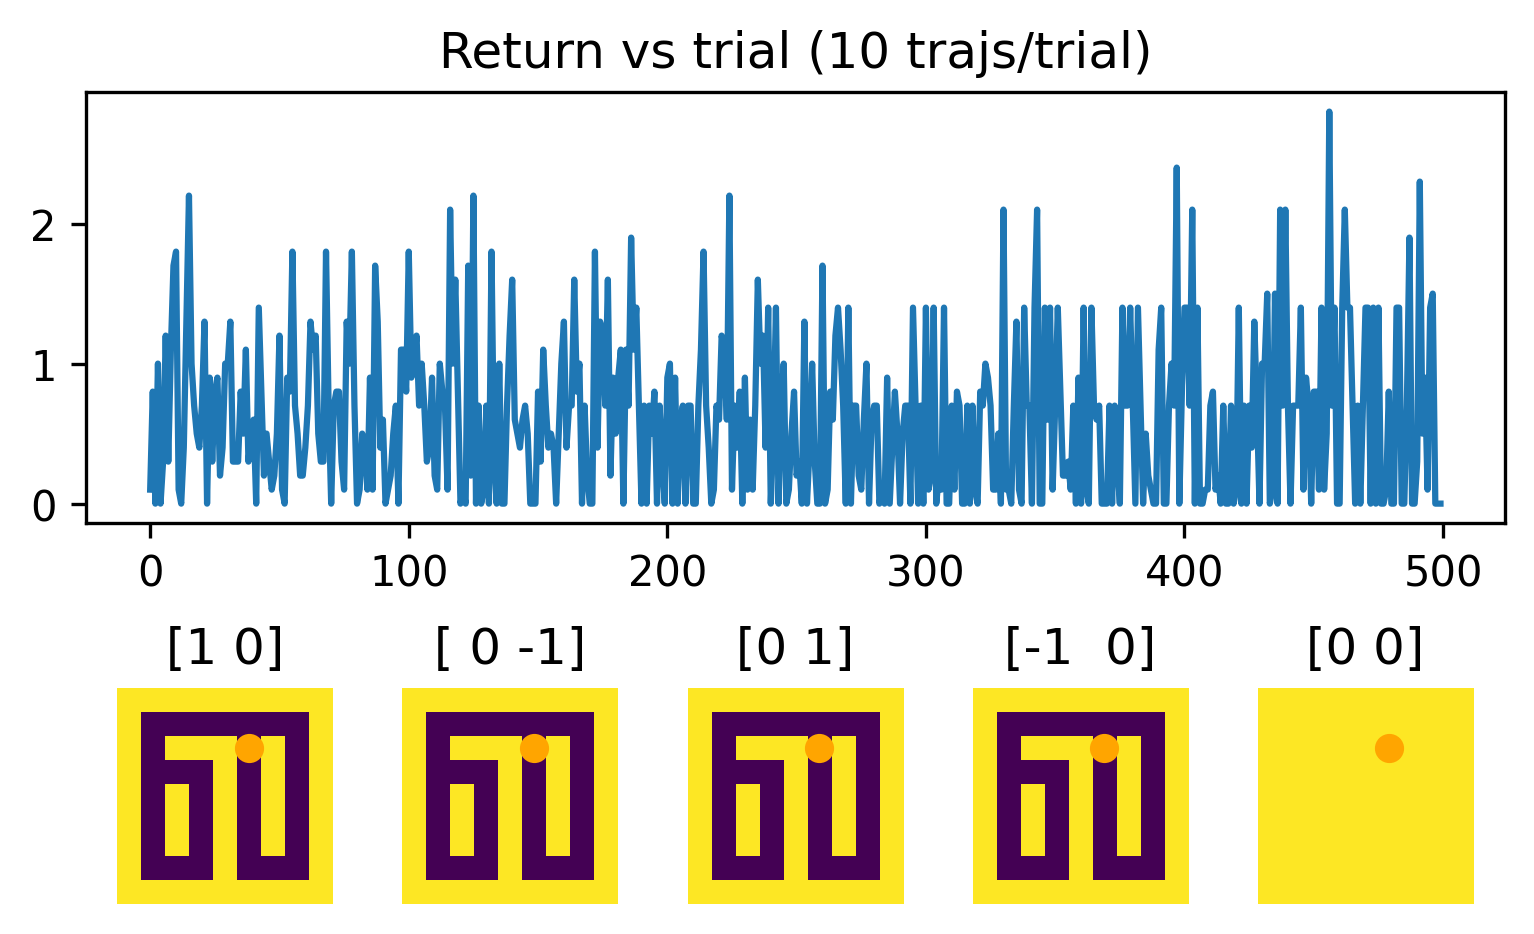

In [420]:
# for fun, try arbitrary mazes (arbitrary position of the chest, random initial pos.)
# this does not yet really work...probably a question of finding
# the right parameters...
run_RL(M=9,eta=0.0005,num_chests=1,delete_treasure=False,
             single_maze=False     ,full_maze=True,   
          batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=True,choose_random_positions_for_single_maze=False,
      place_chest=None,      kernel_size=3)

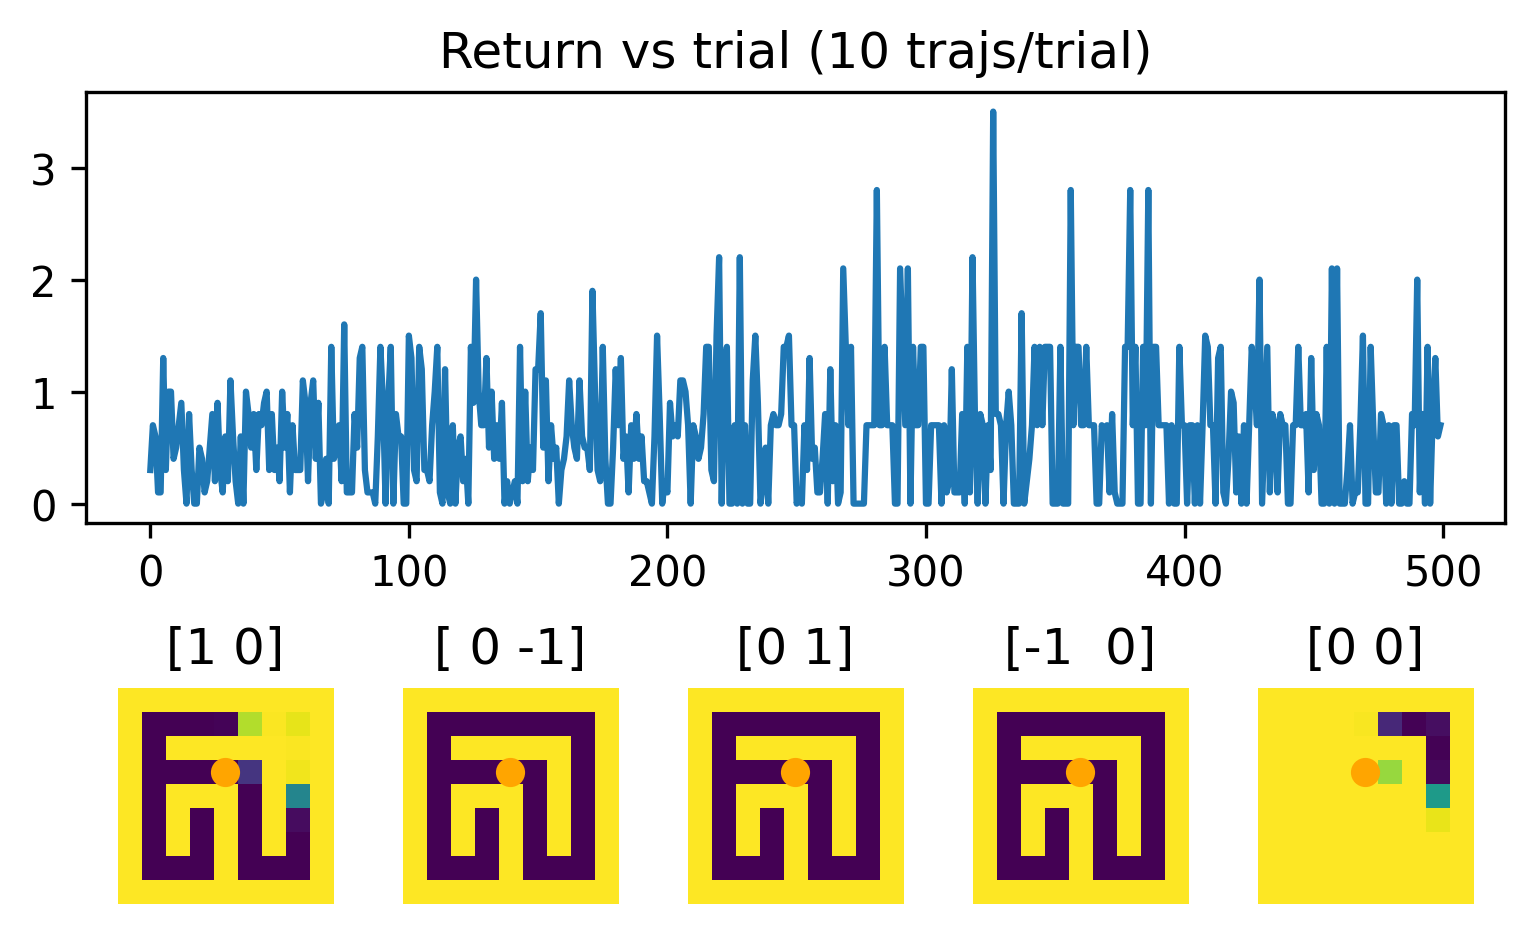

In [421]:
# for fun, try arbitrary mazes (arbitrary position of the chest, random initial pos.)
# this does not yet really work...probably a question of finding
# the right parameters...
run_RL(M=9,eta=0.0005,num_chests=1,delete_treasure=False,
             single_maze=False     ,full_maze=True,   
          batchsize=10,test_batchsize=5,
          nsteps=7,ntrials=500,skipsteps=5,do_visualize=True,
          num_actions=5,do_show_test_batch=False,
          try_adam=True,choose_random_positions_for_single_maze=False,
      place_chest=None,      kernel_size=3)